# **CST4090 - Data Science Project Proposal**
### **IBRAHIM ADEDEJI ADEFILA − M00376514**

## **Problem Statement**
How can Investors and Portfolio Managers in the Middle East Financial Markets minimise risks and maximise the return from stock trading?
1.	How can investors group stocks into classes of similar performance and movement to diversify an investment portfolio?
2.	How can investors predict future stock price and performance to define an appropriate trading strategy?

Risk: The project will fail if we can not predict and group stocks based on Historical Stock Information and Technical Trading Indicators.

## **Initial Hypotheses**
The primary aim of the research is to build and operationalise ML models with historical stock information and technical analysis indicators that will enable investors and portfolio managers alike to develop investment strategies that minimise risks and maximise returns from stock trading. The following hypotheses have been identified and will be tested:

H1: Grouping stocks of similar behaviour based on Technical Trading Indicators will optimise and diversify an investment portfolio.<br/>
H2: Historical Stock Information and Technical Trading Indicators are vital features to predict stock performance.

## **Data Preparation**

In [15]:
# Import required packages, libraries and classes for the project
import statsmodels.api as sm
import sklearn
import seaborn as sb
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings
import matplotlib.pyplot as plt

from finta import TA
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from math import sqrt
from matplotlib import pyplot as plt
from minisom import MiniSom
from mpl_toolkits.mplot3d import Axes3D
from numpy import vstack,array
from numpy.random import rand
from pandas import Series, DataFrame
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from pylab import bone, pcolor, colorbar, plot, show
from pylab import plot,show
from pylab import rcParams
from scipy.cluster.vq import kmeans,vq
from sklearn import metrics
from sklearn import neighbors
from sklearn import preprocessing
from sklearn. model_selection import cross_val_predict
from sklearn. model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [16]:
# Set the default inline ploting parameters
%matplotlib inline
rcParams['figure.figsize'] = 20,16
sb.set_style('white')

# Ignore Warning Messages from output
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [17]:
# Define the host directory for all the historic stock prices csv files and the applicable extension to load into the list object 
directory =r'C:\sandbox\Python\Fundy\Stocks'
filenames = glob.glob(directory + "/*.csv")

# Collect all the historic stock prices into a list object and subsequently into the stockDF Data Frame
reader = []
for filename in filenames:
    reader.append(pd.read_csv(filename))

stockDF = pd.concat(reader, ignore_index=True)

In [18]:
# Display the top 5 observations to confirm that the Stock Dataset is loaded successfully
stockDF.head()

Date Symbol Price  Open  High   Low   Vol. Change %
0  14-Jun-20   1120  59.2  58.7  59.2  58.6  4.46M    0.00%
1  11-Jun-20   1120  59.2    59  59.2  58.5  6.66M   -0.34%
2  10-Jun-20   1120  59.4  59.3  59.5    59  7.51M    0.17%
3   9-Jun-20   1120  59.3    59  59.4  58.6  6.78M    0.68%
4   8-Jun-20   1120  58.9  58.8  59.7  58.6  8.63M    0.34%

In [19]:
# Rename Price and Vol. features, Remove Change % feature, Replace all - symbols in Volume with 0 and display the top 5 observations to confirm the changes
stockDF.rename(columns = {"Price":"Close", "Vol.":"Volume"}, inplace = True)
stockDF.drop(columns='Change %', inplace = True)
stockDF.Volume = stockDF.Volume.replace('-', '0')
stockDF.head()

Date Symbol Close  Open  High   Low Volume
0  14-Jun-20   1120  59.2  58.7  59.2  58.6  4.46M
1  11-Jun-20   1120  59.2    59  59.2  58.5  6.66M
2  10-Jun-20   1120  59.4  59.3  59.5    59  7.51M
3   9-Jun-20   1120  59.3    59  59.4  58.6  6.78M
4   8-Jun-20   1120  58.9  58.8  59.7  58.6  8.63M

In [20]:
# Use string replace and regular expression to convert the "B", "M" and "K" to "1000000000, "1000000" and "1000" respectively
stockDF.Volume = (stockDF.Volume.replace(r'[KMB]+$', '', 
    regex=True).astype(float) * stockDF.Volume.str.extract(r'[\d\.]+([KMB]+)', 
    expand=False).fillna(1).replace(['K','M','B'], [10**3, 10**6, 10**9]).astype(int))

# Remove all the commas in Close, Open, High and Low features and subsequently convert it to float datatype
def removecomma(x):
    if isinstance(x, str):
        return(x.replace(',', ''))
    return(x)

stockDF['Close'] = stockDF['Close'].apply(removecomma).astype('float')
stockDF['Open'] = stockDF['Open'].apply(removecomma).astype('float')
stockDF['High'] = stockDF['High'].apply(removecomma).astype('float')
stockDF['Low'] = stockDF['Low'].apply(removecomma).astype('float')

# Convert the Date feature to a datetime datatype
stockDF['Date'] = pd.to_datetime(stockDF['Date'])

# Display the top 5 observations to confirm the changes
stockDF.head()

Date Symbol  Close  Open  High   Low     Volume
0 2020-06-14   1120   59.2  58.7  59.2  58.6  4460000.0
1 2020-06-11   1120   59.2  59.0  59.2  58.5  6660000.0
2 2020-06-10   1120   59.4  59.3  59.5  59.0  7510000.0
3 2020-06-09   1120   59.3  59.0  59.4  58.6  6780000.0
4 2020-06-08   1120   58.9  58.8  59.7  58.6  8630000.0

In [21]:
# Shortlisted stock candidates for to train the models are selected from the four sectors with varing cluster group
# ('RAKPROP', Cluster = 0), ('QFLS', Cluster = 1), (1120, Cluster = 3) and (2280, Cluster = 5) 
# ('RAKPROP', Sector = SERVICES), ('QFLS', Sector = ENERGY), (1120, Sector = FINANCIAL) and (2280, Sector = CONSUMER)
Stock8030 = stockDF[stockDF['Symbol'] == 8030]
Stock8030 = Stock8030.set_index("Date")

StockQFLS = stockDF[stockDF['Symbol'] == "QFLS"]
StockQFLS = StockQFLS.set_index("Date")

StockRAKPROP = stockDF[stockDF['Symbol'] == "RAKPROP"]
StockRAKPROP = StockRAKPROP.set_index('Date')

StockCATT = stockDF[stockDF['Symbol'] == "CATT"]
StockCATT = StockCATT.set_index("Date")

In [22]:
StockRAKPROP.rename(columns = {"Symbol":"symbol","Close":"close","Open":"open","High":"high","Low":"low", "Volume":"volume"}, inplace = True)
StockRAKPROP ['SMA'] = TA.SMA(StockRAKPROP, 21)
StockRAKPROP ['EMA'] = TA.EMA(StockRAKPROP, 21)
StockRAKPROP ['MOM'] = TA.MOM(StockRAKPROP)
StockRAKPROP ['RSI'] = TA.RSI(StockRAKPROP, 21)
StockRAKPROP ['ROC'] = TA.ROC(StockRAKPROP, 21)
StockRAKPROP ['MACD'] = TA.MACD(StockRAKPROP)['MACD']
StockRAKPROP ['BB'] = TA.BBANDS(StockRAKPROP)['BB_MIDDLE']
StockRAKPROP ['CHAIKIN'] = TA.CHAIKIN(StockRAKPROP)
StockRAKPROP ['STOCH'] = TA.STOCH(StockRAKPROP)
StockRAKPROP ['STOCHD'] = TA.STOCHD(StockRAKPROP)
StockRAKPROP.dropna(inplace=True)
StockRAKPROP.rename(columns = {"symbol":"Symbol","close":"Close","open":"Open","high":"High","low":"Low","volume":"Volume"}, inplace = True)
StockRAKPROP.describe()

Close         Open         High          Low        Volume          SMA          EMA          MOM          RSI          ROC         MACD           BB       CHAIKIN        STOCH        STOCHD
count  1467.000000  1467.000000  1467.000000  1467.000000  1.467000e+03  1467.000000  1467.000000  1467.000000  1467.000000  1467.000000  1467.000000  1467.000000  1.467000e+03  1467.000000  1.467000e+03
mean      0.624202     0.623449     0.632559     0.614835  7.097021e+06     0.619761     0.619695     0.004532    52.136441     1.927629     0.003113     0.619977 -1.077816e+07    53.369044  5.335195e+01
std       0.152746     0.153395     0.156101     0.149645  1.177788e+07     0.148918     0.147926     0.044289     8.478291     9.231490     0.013459     0.149073  1.136394e+07    30.686840  2.767551e+01
min       0.333000     0.335000     0.343000     0.333000  4.200000e+02     0.344762     0.345932    -0.260000    28.098244   -31.250000    -0.039333     0.344200 -9.694255e+07     0.000000  1.894781e-13
25%       0.490000     0.487500     0.493500     0.480000  1.420000e+06     0.488048     0.491404    -0.014000    46.366510    -3.225806    -0.003788     0.488200 -1.350141e+07    28.571429  3.000000e+01
50%       0.620000     0.620000     0.630000     0.610000  3.490000e+06     0.611905     0.610942     0.001000    52.194882     1.449275     0.002293     0.612350 -7.315925e+06    52.631579  5.317460e+01
75%       0.700000     0.700000     0.710000     0.690000  7.660000e+06     0.701190     0.704290     0.021000    58.012296     6.278746     0.010204     0.700750 -3.624126e+06    80.000000  7.956702e+01
max       1.120000     1.120000     1.140000     1.100000  1.405900e+08     1.036667     1.043437     0.220000    80.156333    51.724138     0.047694     1.038000 -3.822796e+05   100.000000  1.000000e+02

In [23]:
StockRAKPROP.head()

Symbol  Close   Open   High    Low     Volume       SMA       EMA    MOM        RSI       ROC      MACD       BB       CHAIKIN      STOCH     STOCHD
Date                                                                                                                                                             
2020-05-11  RAKPROP  0.342  0.345  0.350  0.340  1970000.0  0.345810  0.345932  0.015  45.858643 -3.116147  0.000316  0.34565 -4.341638e+06  45.454545  59.595960
2020-05-10  RAKPROP  0.353  0.345  0.353  0.343   911100.0  0.346000  0.346655  0.009  52.675135  1.146132  0.000749  0.34555 -3.893097e+06  78.787879  57.575758
2020-05-07  RAKPROP  0.343  0.340  0.343  0.340   409010.0  0.345429  0.346285  0.001  47.023857 -3.380282  0.000389  0.34520 -3.353647e+06  48.484848  57.575758
2020-05-06  RAKPROP  0.346  0.365  0.365  0.344  1360000.0  0.345238  0.346257 -0.001  48.755656 -1.142857  0.000313  0.34470 -3.216143e+06  50.000000  59.090909
2020-05-05  RAKPROP  0.350  0.365  0.365  0.350  1630000.0  0.344952  0.346628 -0.003  50.998280 -1.685393  0.000531  0.34420 -3.383549e+06  44.444444  47.643098

In [24]:
StockQFLS.rename(columns = {"Symbol":"symbol","Close":"close","Open":"open","High":"high","Low":"low", "Volume":"volume"}, inplace = True)
StockQFLS ['SMA'] = TA.SMA(StockQFLS, 21)
StockQFLS ['EMA'] = TA.EMA(StockQFLS, 21)
StockQFLS ['MOM'] = TA.MOM(StockQFLS)
StockQFLS ['RSI'] = TA.RSI(StockQFLS, 21)
StockQFLS ['ROC'] = TA.ROC(StockQFLS, 21)
StockQFLS ['MACD'] = TA.MACD(StockQFLS)['MACD']
StockQFLS ['BB'] = TA.BBANDS(StockQFLS)['BB_MIDDLE']
StockQFLS ['CHAIKIN'] = TA.CHAIKIN(StockQFLS)
StockQFLS ['STOCH'] = TA.STOCH(StockQFLS)
StockQFLS ['STOCHD'] = TA.STOCHD(StockQFLS)
StockQFLS.dropna(inplace=True)
StockQFLS.rename(columns = {"symbol":"Symbol","close":"Close","open":"Open","high":"High","low":"Low","volume":"Volume"}, inplace = True)
StockQFLS.describe()

Close         Open         High          Low        Volume          SMA          EMA          MOM          RSI          ROC         MACD           BB       CHAIKIN        STOCH        STOCHD
count  1461.000000  1461.000000  1461.000000  1461.000000  1.461000e+03  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  1.461000e+03  1461.000000  1.461000e+03
mean     15.551303    15.535213    15.677892    15.408362  6.526259e+05    15.538321    15.538110     0.014602    50.721903     0.414914     0.008807    15.538797 -3.827950e+05    53.668926  5.364002e+01
std       3.654744     3.648756     3.674770     3.621226  1.453273e+06     3.622207     3.606460     0.736418    12.077301     7.474137     0.282371     3.623756  1.383498e+06    30.916936  2.872781e+01
min       8.480000     8.450000     8.500000     8.309000  7.360000e+03     8.727476     8.809378    -2.251000    21.812790   -27.237237    -0.808481     8.706350 -2.897270e+06     0.000000  6.454097e-14
25%      13.167000    13.119000    13.235000    13.005000  1.967900e+05    13.167810    13.148868    -0.365000    41.970358    -4.095960    -0.169737    13.170650 -7.589802e+05    23.651961  2.574622e+01
50%      14.526000    14.500000    14.602000    14.441000  3.888900e+05    14.471381    14.463776     0.001000    50.948249     0.332700     0.018391    14.474100 -4.242232e+05    57.934990  5.800000e+01
75%      18.357000    18.349000    18.519000    18.200000  6.986000e+05    18.270667    18.198730     0.350000    59.714520     4.092308     0.167231    18.275550 -1.846456e+05    81.236203  7.845713e+01
max      23.540000    23.500000    23.830000    23.400000  4.312000e+07    23.230476    23.196102     4.680000    81.034093    39.019608     1.035881    23.257000  2.031392e+07   100.000000  9.968920e+01

In [25]:
StockQFLS.describe()

Close         Open         High          Low        Volume          SMA          EMA          MOM          RSI          ROC         MACD           BB       CHAIKIN        STOCH        STOCHD
count  1461.000000  1461.000000  1461.000000  1461.000000  1.461000e+03  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  1.461000e+03  1461.000000  1.461000e+03
mean     15.551303    15.535213    15.677892    15.408362  6.526259e+05    15.538321    15.538110     0.014602    50.721903     0.414914     0.008807    15.538797 -3.827950e+05    53.668926  5.364002e+01
std       3.654744     3.648756     3.674770     3.621226  1.453273e+06     3.622207     3.606460     0.736418    12.077301     7.474137     0.282371     3.623756  1.383498e+06    30.916936  2.872781e+01
min       8.480000     8.450000     8.500000     8.309000  7.360000e+03     8.727476     8.809378    -2.251000    21.812790   -27.237237    -0.808481     8.706350 -2.897270e+06     0.000000  6.454097e-14
25%      13.167000    13.119000    13.235000    13.005000  1.967900e+05    13.167810    13.148868    -0.365000    41.970358    -4.095960    -0.169737    13.170650 -7.589802e+05    23.651961  2.574622e+01
50%      14.526000    14.500000    14.602000    14.441000  3.888900e+05    14.471381    14.463776     0.001000    50.948249     0.332700     0.018391    14.474100 -4.242232e+05    57.934990  5.800000e+01
75%      18.357000    18.349000    18.519000    18.200000  6.986000e+05    18.270667    18.198730     0.350000    59.714520     4.092308     0.167231    18.275550 -1.846456e+05    81.236203  7.845713e+01
max      23.540000    23.500000    23.830000    23.400000  4.312000e+07    23.230476    23.196102     4.680000    81.034093    39.019608     1.035881    23.257000  2.031392e+07   100.000000  9.968920e+01

In [26]:
Stock8030.rename(columns = {"Symbol":"symbol","Close":"close","Open":"open","High":"high","Low":"low", "Volume":"volume"}, inplace = True)
Stock8030 ['SMA'] = TA.SMA(Stock8030, 21)
Stock8030 ['EMA'] = TA.EMA(Stock8030, 21)
Stock8030 ['MOM'] = TA.MOM(Stock8030)
Stock8030 ['RSI'] = TA.RSI(Stock8030, 21)
Stock8030 ['ROC'] = TA.ROC(Stock8030, 21)
Stock8030 ['MACD'] = TA.MACD(Stock8030)['MACD']
Stock8030 ['BB'] = TA.BBANDS(Stock8030)['BB_MIDDLE']
Stock8030 ['CHAIKIN'] = TA.CHAIKIN(Stock8030)
Stock8030 ['STOCH'] = TA.STOCH(Stock8030)
Stock8030 ['STOCHD'] = TA.STOCHD(Stock8030)
Stock8030.dropna(inplace=True)
Stock8030.rename(columns = {"symbol":"Symbol","close":"Close","open":"Open","high":"High","low":"Low","volume":"Volume"}, inplace = True)
Stock8030.describe()

Close         Open         High          Low        Volume          SMA          EMA          MOM          RSI          ROC         MACD           BB       CHAIKIN        STOCH       STOCHD
count  1460.000000  1460.000000  1460.000000  1460.000000  1.460000e+03  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  1.460000e+03  1460.000000  1460.000000
mean     34.722322    34.745986    35.522623    34.075877  7.153444e+05    34.628392    34.619318     0.096137    51.480019     2.763038     0.082582    34.633121  1.216561e+06    48.440827    48.445156
std      18.327757    18.359492    18.843721    17.905730  7.409588e+05    18.037620    17.883499     5.900157    11.922250    20.503520     2.030330    18.052196  3.056006e+06    30.453166    28.648809
min      12.680000    12.620000    13.100000    12.520000  1.232000e+04    13.943810    14.133208   -41.700000    18.990742   -66.872852   -11.613855    13.935000 -3.848914e+06     0.000000     0.903449
25%      16.395000    16.392500    16.700000    16.195000  2.265075e+05    16.323690    16.351982    -1.690000    43.254615    -8.804076    -0.583362    16.320500 -3.229987e+05    19.184673    20.925146
50%      32.485000    32.530000    32.950000    32.080000  4.611450e+05    32.871905    33.373304     0.120000    52.205660     0.999119     0.125100    32.818250  1.314504e+05    48.689573    48.019286
75%      52.100000    52.152500    52.880000    51.152500  9.653325e+05    52.022143    52.046662     1.860000    60.724685    10.588235     0.932811    52.046125  1.600138e+06    77.790179    75.305215
max      79.000000    78.000000    79.000000    74.250000  6.440000e+06    70.535714    69.869907    25.620000    84.017435   108.771930     6.817430    70.962500  2.126970e+07   100.000000    99.240639

In [27]:
Stock8030.head()

Symbol  Close   Open   High    Low     Volume        SMA        EMA   MOM        RSI        ROC      MACD      BB       CHAIKIN      STOCH     STOCHD
Date                                                                                                                                                            
2020-05-07   8030  18.38  18.02  18.50  17.90  1740000.0  21.050476  20.264526 -2.10  34.211981 -11.464355 -0.669480  21.045  2.565820e+06  23.204420  23.319222
2020-05-06   8030  18.00  17.90  18.48  17.78  1160000.0  20.900000  20.032779 -2.30  32.519916 -14.933837 -0.728218  20.855  2.090245e+06  20.634921  22.405321
2020-05-05   8030  17.54  17.20  17.60  17.14   789790.0  20.697143  19.780555 -2.64  30.596496 -19.541284 -0.796867  20.622  1.772321e+06  14.432990  19.424110
2020-05-04   8030  17.00  16.30  17.12  16.14   986010.0  20.449524  19.502075 -3.66  28.517466 -23.423423 -0.878414  20.357  1.711082e+06  13.564669  16.210860
2020-05-03   8030  16.32  17.50  17.60  16.32  1180000.0  20.164762  19.186300 -5.34  26.166536 -26.816143 -0.979347  20.043  1.155662e+06   2.839117  10.278925

In [28]:
StockCATT.rename(columns = {"Symbol":"symbol","Close":"close","Open":"open","High":"high","Low":"low", "Volume":"volume"}, inplace = True)
StockCATT ['SMA'] = TA.SMA(StockCATT, 21)
StockCATT ['EMA'] = TA.EMA(StockCATT, 21)
StockCATT ['MOM'] = TA.MOM(StockCATT)
StockCATT ['RSI'] = TA.RSI(StockCATT, 21)
StockCATT ['ROC'] = TA.ROC(StockCATT, 21)
StockCATT ['MACD'] = TA.MACD(StockCATT)['MACD']
StockCATT ['BB'] = TA.BBANDS(StockCATT)['BB_MIDDLE']
StockCATT ['CHAIKIN'] = TA.CHAIKIN(StockCATT)
StockCATT ['STOCH'] = TA.STOCH(StockCATT)
StockCATT ['STOCHD'] = TA.STOCHD(StockCATT)
StockCATT.dropna(inplace=True)
StockCATT.rename(columns = {"symbol":"Symbol","close":"Close","open":"Open","high":"High","low":"Low","volume":"Volume"}, inplace = True)
StockCATT.describe()

Close         Open         High          Low        Volume          SMA          EMA          MOM          RSI          ROC         MACD           BB       CHAIKIN        STOCH       STOCHD
count  1053.000000  1053.000000  1053.000000  1053.000000  1.053000e+03  1053.000000  1053.000000  1053.000000  1053.000000  1053.000000  1053.000000  1053.000000  1.053000e+03  1053.000000  1053.000000
mean    183.022792   181.404558   184.105413   180.159544  7.525140e+04   182.661964   182.692581     0.400760    50.765768     0.851849     0.178432   182.675166  1.498072e+06    57.832216    57.846138
std      42.521918    42.190831    42.954429    41.676639  2.289994e+05    41.477193    41.136455    14.150094     8.450177    10.283265     4.756678    41.513706  2.689003e+06    35.087473    30.903769
min      99.000000   100.000000   102.000000    99.000000  0.000000e+00   104.809524   105.227312   -66.000000    32.131642   -33.009709   -13.601570   104.650000 -7.116682e+04     0.000000     0.000000
25%     140.000000   138.000000   142.000000   138.000000  9.000000e+02   140.000000   140.020482    -6.000000    44.209852    -5.687204    -2.452022   140.200000  1.816460e+05    25.000000    30.303030
50%     188.000000   186.000000   189.000000   185.000000  1.220000e+04   187.095238   186.451016     1.000000    50.828117     1.470588     0.508822   187.200000  4.262223e+05    64.000000    64.444444
75%     214.000000   210.000000   214.000000   208.000000  5.150000e+04   213.142857   213.962939     8.000000    56.402860     6.557377     3.143408   213.100000  1.308085e+06    90.909091    86.021505
max     300.000000   298.000000   338.000000   297.000000  2.620000e+06   282.857143   282.290917    48.000000    77.255729    45.161290    12.463027   283.000000  1.818839e+07   100.000000   100.000000

In [29]:
StockCATT.head()

Symbol  Close   Open   High    Low     Volume         SMA         EMA   MOM        RSI       ROC      MACD      BB       CHAIKIN       STOCH      STOCHD
Date                                                                                                                                                               
2020-05-07   CATT  195.0  195.0  195.0  195.0      100.0  184.238095  186.314229  11.0  72.685145  8.333333  2.093320  184.30  1.769128e+06  100.000000  100.000000
2020-05-06   CATT  193.0  196.0  196.0  193.0   510920.0  184.714286  186.998438  13.0  67.408833  5.464481  2.248883  184.75  1.311496e+06   84.210526   94.736842
2020-05-05   CATT  190.0  191.0  196.0  189.0  1340000.0  185.000000  187.302141  10.0  60.492629  3.260870  2.136921  185.25  1.049984e+06   68.421053   84.210526
2020-05-04   CATT  187.0  180.0  196.0  180.0  1990000.0  185.333333  187.271880   1.0  54.609499  3.888889  1.816211  185.60  4.864569e+06   52.631579   68.421053
2020-05-03   CATT  179.0  180.0  180.0  179.0   352490.0  185.285714  186.451016  -6.0  42.921525 -0.555556  0.983539  185.55  5.383201e+06   10.526316   43.859649

In [30]:
# Extract the Dates, Symbols and Close Stocks' Values of all the 50 shortlisted companies from stockDF Data Frame and restructure into a pivot table in stockDFClose Data Frame.
stockDFClose = stockDF[["Date", "Symbol", "Close"]]
stockDFClose = pd.pivot_table(stockDFClose,index='Date',columns='Symbol',values='Close')

# Display the Top 5 Observations to confirm that the stockDFClose Data Frame is structured properly
stockDFClose.head()

Symbol       1120  1180   2030   2280  4250  4280   7010   7020  8010  8030   AAIT   ABOB  ADCB  ADIB  AGTHIA  ALDAR   BKMB   BKSB   BOUK   BRES   BURG  CATT   COMB  DANA   ERES  ETISALAT    FAB   GBKK  GPIK   HBMO   HUMN   IHGS    KFH   MABK   MERS   NBKK   OFCI   OIFC   ORDS   OTEL    QFLS   QINS  QISB    QNBK  RAKPROP   RNSS   SIB   SIHC  WAHA   ZAIN
Date                                                                                                                                                                                                                                                                                                                                                               
2014-06-15  43.17   NaN  74.00  54.00  47.4  25.4  67.00  82.75  42.9  32.5  0.277    NaN  7.20  6.16    6.13   3.86  0.602  0.222  472.0  4.075  509.0   NaN  5.392  0.79  2.220     10.50  13.32  319.0  76.2  0.158    NaN  6.326  653.0  861.0  17.93  859.0  0.089  0.302  14.39  1.600  18.221  4.460  9.60  13.652     1.06    NaN  1.83  0.230  2.84  660.0
2014-06-16  42.50   NaN  72.50  52.69  45.7  25.4  66.00  82.25  41.8  32.6  0.274  0.162  6.99  5.88    6.13   3.82  0.613  0.225  472.0  3.920  519.0   NaN  5.409  0.72  2.182     10.36  13.59  329.0  75.2    NaN  332.0  6.189  645.0  878.0  17.10  868.0  0.090  0.304  14.30  1.605  18.009  4.326  9.40  13.424     1.03    NaN  1.90  0.235  2.68  650.0
2014-06-17  42.91   NaN  74.00  53.44  46.5  25.0  66.25  81.75  41.1  32.9  0.274  0.159  6.98  6.05    6.00   3.82  0.610  0.226  463.0  3.900  500.0   NaN  5.392  0.75  2.170     10.36  12.73  329.0  74.3  0.157    NaN  6.240  636.0  861.0  16.80  859.0  0.092  0.302  13.60  1.595  18.272  4.293  9.33  13.424     1.06  0.652  1.90  0.232  2.83  650.0
2014-06-18  43.24   NaN  73.75  53.81  47.3  25.5  66.50  82.00  41.4  33.9  0.274  0.163  7.25  6.16    6.00   3.87  0.606  0.225  463.0  3.885  500.0   NaN  5.409  0.74  2.150     10.32  13.27  319.0  71.4    NaN    NaN  6.163  628.0  878.0  16.80  859.0  0.092  0.306  13.31  1.605  18.400  4.287  9.30  13.864     1.06    NaN  1.90  0.237  2.86  640.0
2014-06-19  43.56   NaN  73.25  53.62  47.1  25.0  67.25  82.75  41.2  34.1  0.275  0.163  7.44  6.12    5.70   3.95  0.617  0.225  463.0  3.870  490.0   NaN  5.459  0.75  2.172     10.36  13.41  324.0  70.5  0.158    NaN  6.172  628.0  861.0  16.89  859.0  0.093  0.304  13.00  1.605  18.247  4.460  9.16  13.333     1.06  0.644  1.90  0.235  2.90  640.0

In [31]:
# Review the summary of the stockDFClose Data Frame to determine if there are missing values or irregular entries.
stockDFClose.describe()

Symbol         1120         1180         2030         2280         4250         4280         7010         7020         8010         8030         AAIT        ABOB         ADCB         ADIB       AGTHIA        ALDAR         BKMB         BKSB         BOUK         BRES         BURG         CATT         COMB         DANA         ERES     ETISALAT          FAB         GBKK         GPIK         HBMO         HUMN         IHGS          KFH         MABK         MERS         NBKK         OFCI         OIFC         ORDS         OTEL         QFLS         QINS         QISB         QNBK      RAKPROP         RNSS          SIB         SIHC         WAHA         ZAIN
count   1495.000000  1397.000000  1494.000000  1495.000000  1495.000000  1494.000000  1494.000000  1447.000000  1495.000000  1481.000000  1448.000000  970.000000  1480.000000  1495.000000  1457.000000  1501.000000  1464.000000  1353.000000  1478.000000  1486.000000  1476.000000  1074.000000  1482.000000  1489.000000  1482.000000  1489.000000  1492.000000  1468.000000  1454.000000  1146.000000  1263.000000  1472.000000  1476.000000  1468.000000  1482.000000  1479.000000  1363.000000  1397.000000  1484.000000  1456.000000  1482.000000  1477.000000  1486.000000  1484.000000  1488.000000  1128.000000  1324.000000  1259.000000  1459.000000  1478.000000
mean      47.649538    43.598984    43.005556    53.729692    50.974495    12.104913    77.370850    27.910408    77.952843    34.530068     0.146831    0.166333     7.284284     4.298485     5.500714     2.359760     0.415008     0.139005   430.506766     3.707326   327.837398   183.032588     4.146091     0.707395     1.326188    15.858012    11.757949   263.694142    41.963274     0.121818  2565.414093     5.501192   540.620596   734.297684    17.714733   743.437458     0.085581     0.161515     8.672790     1.199346    15.563930     4.726814    11.947123    15.480606     0.620281     0.391367     1.345850     0.119438     1.910781   469.108254
std       11.334110    12.451095    13.409966     7.486984    16.826352     5.211779    14.902213    17.026419    16.265289    18.268726     0.051219    0.032494     1.035690     0.905289     1.551876     0.508395     0.085654     0.035967    71.209977     0.570452    75.535714    42.107503     0.938029     0.216912     0.459636     2.730190     2.298463    32.103187    21.285313     0.018485  1244.127753     3.475396   116.267819    99.598310     3.507331   122.470714     0.031580     0.055923     1.881245     0.436331     3.630681     1.306947     2.499135     2.509303     0.155171     0.176759     0.255199     0.034839     0.614002    85.403668
min       29.480000    21.730000    21.500000    33.000000    19.800000     5.900000    52.750000    13.000000    39.500000    12.680000     0.060000    0.105000     3.820000     3.000000     2.520000     1.430000     0.302000     0.077000   336.000000     2.600000   182.000000    99.000000     2.575000     0.380000     0.462000     9.410000     6.900000   187.000000    12.600000     0.086000   332.000000     1.271000   364.000000   498.000000    13.000000   508.000000     0.042000     0.076000     5.097000     0.520000     8.480000     1.970000     7.730000    11.136000     0.327000     0.110000     0.951000     0.058000     0.628000   320.000000
25%       39.400000    33.600000    34.000000    48.200000    34.975000     8.217500    66.500000    19.000000    66.725000    16.420000     0.100000    0.139000     6.800000     3.590000     3.980000     2.080000     0.357000     0.116000   371.000000     3.350000   280.000000   142.500000     3.355000     0.530000     0.931000    15.000000    10.150000   240.000000    26.000000     0.111000  1100.000000     2.440000   455.000000   647.000000    14.950000   654.500000     0.061000     0.112000     7.140000     0.732000    13.202000     3.590000    10.030000    13.570000     0.480000     0.222000     1.152000     0.094000     1.720000   410.000000
50%       42.870000    44.000000    40.000000    53.800000    53

In [32]:
# Imputate the missing values, which are days when the stocks were not traded. 
# The imputation methodology is to use either the stock close value of the day before or the day after.
while stockDFClose.isnull().values.any():
    stockDFClose = stockDFClose.fillna(stockDFClose.shift())
    stockDFClose = stockDFClose.fillna(stockDFClose.shift(-1))
stockDFClose.describe()

Symbol         1120         1180         2030         2280         4250         4280         7010         7020         8010         8030         AAIT         ABOB         ADCB         ADIB       AGTHIA        ALDAR         BKMB         BKSB         BOUK         BRES         BURG         CATT         COMB         DANA         ERES     ETISALAT          FAB         GBKK         GPIK         HBMO         HUMN         IHGS          KFH         MABK         MERS         NBKK         OFCI         OIFC         ORDS         OTEL         QFLS         QINS         QISB         QNBK      RAKPROP         RNSS          SIB         SIHC         WAHA         ZAIN
count   1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000
mean      47.663575    44.330117    43.091977    53.792720    50.995806    12.133085    77.387606    28.308200    77.954566    34.428089     0.146444     0.162001     7.283568     4.295868     5.473823     2.358089     0.415718     0.138139   431.015003     3.707457   327.612524   186.330724     4.144641     0.706661     1.327463    15.878265    11.743275   263.635356    42.114938     0.121611  2337.642531     5.495218   541.259622   734.414220    17.725300   744.149380     0.084468     0.161256     8.681992     1.199642    15.545109     4.735471    11.935233    15.471040     0.619596     0.400556     1.346576     0.116746     1.892901   469.493803
std       11.305924    12.304038    13.499572     7.530279    16.819220     5.234482    14.894573    17.180265    16.246787    18.221843     0.051533     0.031695     1.027610     0.901560     1.561707     0.506234     0.086364     0.035499    71.429934     0.569845    75.704204    41.917653     0.941640     0.217016     0.458462     2.721653     2.305596    32.092811    21.286202     0.017677  1309.704019     3.464781   116.479855    99.923574     3.503773   122.484439     0.030822     0.055822     1.882679     0.436124     3.627315     1.304847     2.493352     2.508783     0.154315     0.178202     0.247833     0.034788     0.617666    85.561527
min       29.480000    21.730000    21.500000    33.000000    19.800000     5.900000    52.750000    13.000000    39.500000    12.680000     0.060000     0.105000     3.820000     3.000000     2.520000     1.430000     0.302000     0.077000   336.000000     2.600000   182.000000    99.000000     2.575000     0.380000     0.462000     9.410000     6.900000   187.000000    12.600000     0.086000   332.000000     1.271000   364.000000   498.000000    13.000000   508.000000     0.042000     0.076000     5.097000     0.520000     8.480000     1.970000     7.730000    11.136000     0.327000     0.110000     0.951000     0.058000     0.628000   320.000000
25%       39.400000    34.000000    34.000000    48.300000    35.000000     8.250000    66.500000    19.220000    66.800000    16.440000     0.100000     0.137000     6.800000     3.590000     3.950000     2.080000     0.357000     0.113000   371.000000     3.350000   279.000000   156.000000     3.341000     0.530000     0.931000    15.100000    10.150000   240.000000    26.100000     0.112000   940.000000     2.450000   455.000000   647.000000    14.970000   656.000000     0.060000     0.112000     7.140000     0.732000    13.200000     3.595000    10.020000    13.561000     0.480000     0.225000     1.162000     0.091000     1.710000   410.000000
50%       42.950000    45.200000    40.000000    53.800000

In [33]:
# Convert the Date feature to a datetime datatype, set it as the index for the dataframe and convert to Pivot Table
stockDF['Date'] = pd.to_datetime(stockDF['Date'])
stockDF = pd.pivot_table(stockDF,index='Date',columns=['Symbol'], values=['Close', 'Open', 'High', 'Low', 'Volume'])
# Display the top 5 observations to confirm the changes
stockDF.head()

Close                                                                                                                                                              ...     Volume                                                                                                                                                                                                                                                               
Symbol       1120 1180   2030   2280  4250  4280   7010   7020  8010  8030   AAIT   ABOB  ADCB  ADIB AGTHIA ALDAR   BKMB   BKSB   BOUK   BRES   BURG CATT   COMB  DANA   ERES  ...   ETISALAT        FAB       GBKK       GPIK      HBMO    HUMN      IHGS        KFH       MABK       MERS       NBKK      OFCI       OIFC       ORDS      OTEL       QFLS       QINS       QISB       QNBK     RAKPROP      RNSS       SIB      SIHC       WAHA       ZAIN
Date                                                                                                                                                                           ...                                                                                                                                                                                                                                                                          
2014-06-15  43.17  NaN  74.00  54.00  47.4  25.4  67.00  82.75  42.9  32.5  0.277    NaN  7.20  6.16   6.13  3.86  0.602  0.222  472.0  4.075  509.0  NaN  5.392  0.79  2.220  ...  1900000.0   404930.0   872220.0  4230000.0   60000.0     NaN  199030.0  3330000.0   685160.0   149820.0  4310000.0   20240.0   670870.0  1020000.0  266320.0   931720.0   759780.0  1010000.0  3790000.0  13250000.0       NaN  751750.0   10400.0  2380000.0  3670000.0
2014-06-16  42.50  NaN  72.50  52.69  45.7  25.4  66.00  82.25  41.8  32.6  0.274  0.162  6.99  5.88   6.13  3.82  0.613  0.225  472.0  3.920  519.0  NaN  5.409  0.72  2.182  ...  2960000.0  2780000.0   477420.0  1140000.0       NaN  9640.0  159400.0   871170.0   446110.0   353260.0  1430000.0   47760.0   305960.0   770720.0  628690.0   982840.0  8640000.0  2780000.0  3030000.0  17000000.0       NaN  373000.0  359570.0  4240000.0  3320000.0
2014-06-17  42.91  NaN  74.00  53.44  46.5  25.0  66.25  81.75  41.1  32.9  0.274  0.159  6.98  6.05   6.00  3.82  0.610  0.226  463.0  3.900  500.0  NaN  5.392  0.75  2.170  ...  1480000.0  1170000.0  1090000.0   588100.0  170030.0     NaN  219950.0  9780000.0  1060000.0  1730000.0  1430000.0   61000.0   919900.0  2530000.0  334260.0  1220000.0  4790000.0  2120000.0  6320000.0  14770000.0   37100.0  359510.0  306860.0  2950000.0  1800000.0
2014-06-18  43.24  NaN  73.75  53.81  47.3  25.5  66.50  82.00  41.4  33.9  0.274  0.163  7.25  6.16   6.00  3.87  0.606  0.225  463.0  3.885  500.0  NaN  5.409  0.74  2.150  ...  2110000.0  1850000.0  1180000.0  2630000.0       NaN     NaN  173240.0  5360000.0   561860.0   346510.0  4580000.0   35040.0   907560.0  2400000.0  285470.0   668690.0   414210.0   997140.0  4660000.0   6800000.0       NaN   40000.0  483470.0  2200000.0  7020000.0
2014-06-19  43.56  NaN  73.25  53.62  47.1  25.0  67.25  82.75  41.2  34.1  0.275  0.163  7.44  6.12   5.70  3.95  0.617  0.225  463.0  3.870  490.0  NaN  5.459  0.75  2.172  ...  1960000.0  1820000.0   476740.0  1120000.0  301260.0     NaN  157900.0  2940000.0   941190.0   234790.0  3180000.0  100010.0  1030000.0  2520000.0  541670.0   488820.0  1190000.0  2450000.0  4490000.0  19480000.0  270380.0  210000.0  291770.0  1320000.0  6180000.0

[5 rows x 250 columns]

In [34]:
stockDF.describe()

Close                                                                                                                                                                                                                                                                                                                         ...        Volume                                                                                                                                                                                                                                                                                                                                                
Symbol         1120         1180         2030         2280         4250         4280         7010         7020         8010         8030         AAIT        ABOB         ADCB         ADIB       AGTHIA        ALDAR         BKMB         BKSB         BOUK         BRES         BURG         CATT         COMB         DANA         ERES  ...      ETISALAT           FAB          GBKK          GPIK          HBMO          HUMN          IHGS           KFH          MABK          MERS          NBKK          OFCI          OIFC          ORDS          OTEL          QFLS          QINS          QISB          QNBK       RAKPROP          RNSS           SIB          SIHC          WAHA          ZAIN
count   1495.000000  1397.000000  1494.000000  1495.000000  1495.000000  1494.000000  1494.000000  1447.000000  1495.000000  1481.000000  1448.000000  970.000000  1480.000000  1495.000000  1457.000000  1501.000000  1464.000000  1353.000000  1478.000000  1486.000000  1476.000000  1074.000000  1482.000000  1489.000000  1482.000000  ...  1.489000e+03  1.492000e+03  1.468000e+03  1.454000e+03  1.146000e+03  1.263000e+03  1.472000e+03  1.476000e+03  1.468000e+03  1.482000e+03  1.479000e+03  1.363000e+03  1.397000e+03  1.484000e+03  1.456000e+03  1.482000e+03  1.477000e+03  1.486000e+03  1.484000e+03  1.488000e+03  1.128000e+03  1.324000e+03  1.259000e+03  1.459000e+03  1.478000e+03
mean      47.649538    43.598984    43.005556    53.729692    50.974495    12.104913    77.370850    27.910408    77.952843    34.530068     0.146831    0.166333     7.284284     4.298485     5.500714     2.359760     0.415008     0.139005   430.506766     3.707326   327.837398   183.032588     4.146091     0.707395     1.326188  ...  1.848116e+06  2.610650e+06  3.201351e+06  3.528301e+06  1.489928e+06  1.157096e+05  8.633383e+05  4.811246e+06  4.804175e+05  2.858847e+05  3.230262e+06  5.057459e+05  5.597051e+05  1.212344e+06  2.344382e+05  6.522801e+05  1.723247e+06  1.104169e+06  2.834205e+06  7.060250e+06  3.028749e+05  7.027278e+05  3.413579e+05  1.933838e+06  3.367241e+06
std       11.334110    12.451095    13.409966     7.486984    16.826352     5.211779    14.902213    17.026419    16.265289    18.268726     0.051219    0.032494     1.035690     0.905289     1.551876     0.508395     0.085654     0.035967    71.209977     0.570452    75.535714    42.107503     0.938029     0.216912     0.459636  ...  3.956334e+06  1.069560e+07  5.670359e+06  5.133904e+06  3.019512e+07  2.084226e+05  1.588421e+06  5.164044e+06  7.473617e+05  5.058427e+05  4.950180e+06  9.388808e+05  8.527624e+05  1.104971e+06  3.825055e+05  1.443779e+06  5.320494e+06  1.519525e+06  4.984392e+06  1.170658e+07  4.867553e+05  2.200109e+06  6.602308e+05  3.711651e+06  3.873948e+06
min       29.480000    21.730000    21.500000    33.000000    19.800000     5.900000    52.750000    13.000000    39.500000    12.680000     0.060000    0.105000     3.820000     3.000000     2.520000     1.430000     0.302000     0.077000   336.000000     2.600000   182.000000    99.000000     2.575000     0.380000     0.462000  ...  1.551000e+04  0.000000e+00  1.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  6.425000e+04  0.000000e+00  5.000000e+02  8.300000e+03  1.000000e+02  0.000000e+00  9.970000e+03  5.000000e+01  7.360000e+03  5.000000e+02  5.500000e

## **Exploratory Data Analysis**

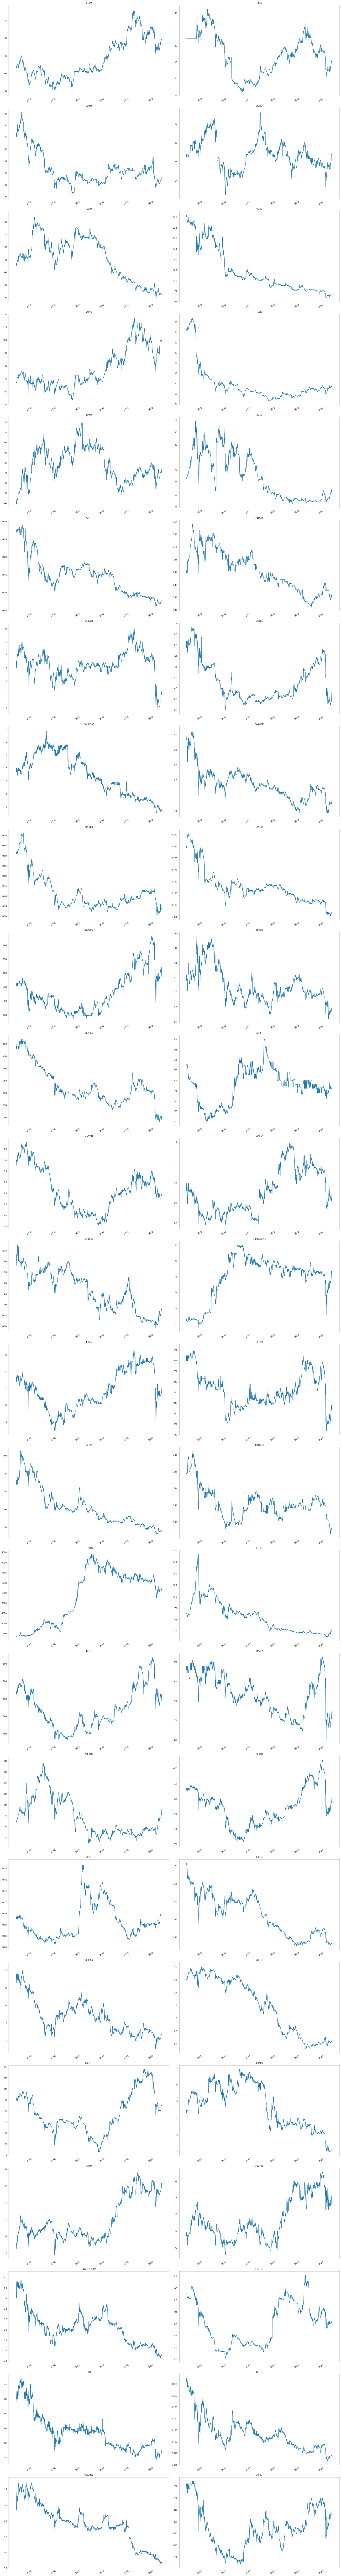

In [35]:
# Plot the Closing Prices of all the 50 Stocks to visualise and examine the stock price trend and volatility.
DFcols = stockDFClose.columns
fig, axs = plt.subplots(nrows=25, ncols=2)
fig.set_size_inches(20, 150)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=1)
for col, ax in zip(DFcols, axs.flatten()):
    ax.plot(stockDFClose[col])
    ax.set_title(col)
    ax.tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.show()

### Plot the Stock Price Movements by Country

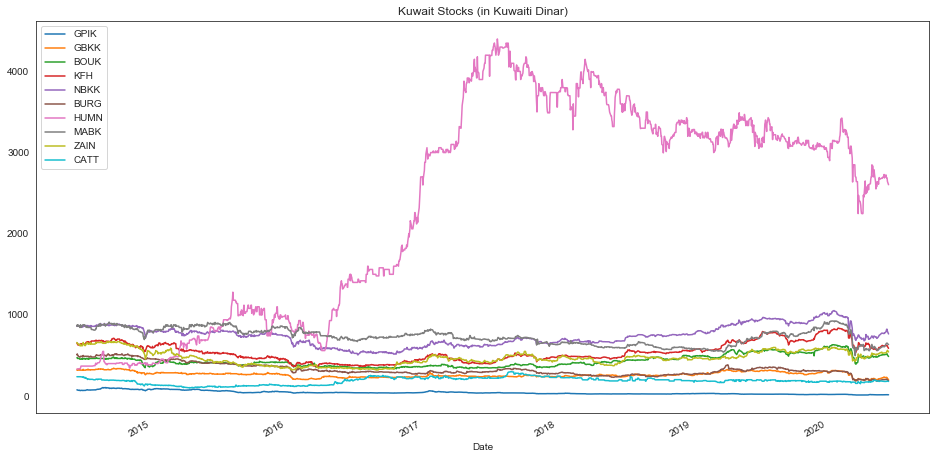

In [36]:
# Plot the Stock Price Movements of Kuwait Stocks in Kuwaiti Dinar
stockDFClose['GPIK'].plot(label='GPIK', figsize = (16,8))
stockDFClose['GBKK'].plot(label='GBKK')
stockDFClose['BOUK'].plot(label='BOUK')
stockDFClose['KFH'].plot(label='KFH')
stockDFClose['NBKK'].plot(label='NBKK')
stockDFClose['BURG'].plot(label='BURG')
stockDFClose['HUMN'].plot(label='HUMN')
stockDFClose['MABK'].plot(label='MABK')
stockDFClose['ZAIN'].plot(label='ZAIN')
stockDFClose['CATT'].plot(label='CATT')
plt.title('Kuwait Stocks (in Kuwaiti Dinar)')
plt.legend();

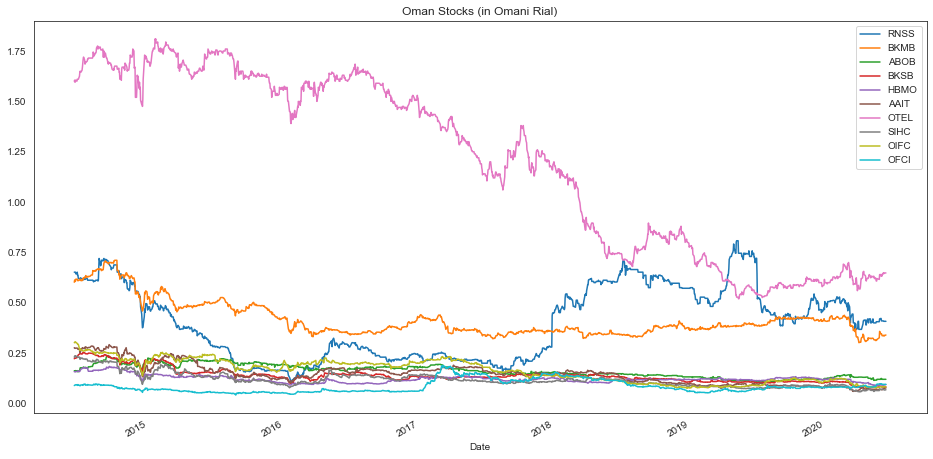

In [37]:
# Plot the Stock Price Movements of Oman Stocks in Omani Rial
stockDFClose['RNSS'].plot(label='RNSS', figsize = (16,8))
stockDFClose['BKMB'].plot(label='BKMB')
stockDFClose['ABOB'].plot(label='ABOB')
stockDFClose['BKSB'].plot(label='BKSB')
stockDFClose['HBMO'].plot(label='HBMO')
stockDFClose['AAIT'].plot(label='AAIT')
stockDFClose['OTEL'].plot(label='OTEL')
stockDFClose['SIHC'].plot(label='SIHC')
stockDFClose['OIFC'].plot(label='OIFC')
stockDFClose['OFCI'].plot(label='OFCI')
plt.title('Oman Stocks (in Omani Rial)')
plt.legend();

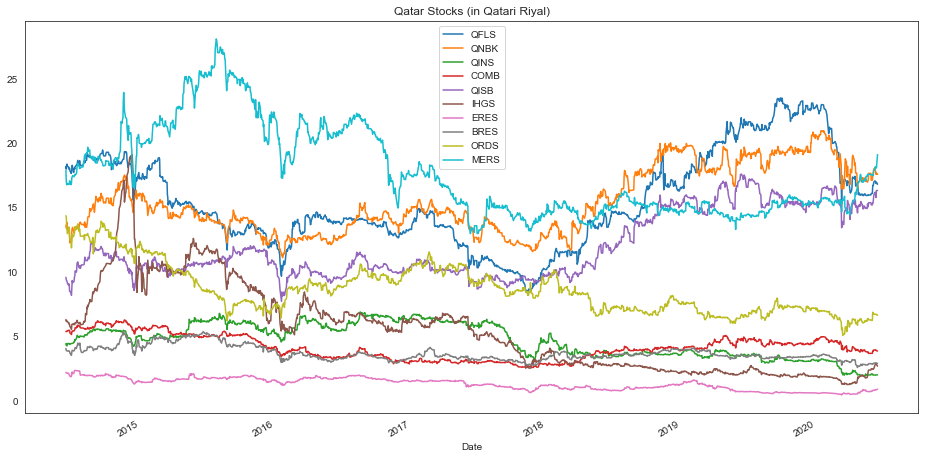

In [38]:
# Plot the Stock Price Movements of Qatar Stocks in Qatari Riyal
stockDFClose['QFLS'].plot(label='QFLS', figsize = (16,8))
stockDFClose['QNBK'].plot(label='QNBK')
stockDFClose['QINS'].plot(label='QINS')
stockDFClose['COMB'].plot(label='COMB')
stockDFClose['QISB'].plot(label='QISB')
stockDFClose['IHGS'].plot(label='IHGS')
stockDFClose['ERES'].plot(label='ERES')
stockDFClose['BRES'].plot(label='BRES')
stockDFClose['ORDS'].plot(label='ORDS')
stockDFClose['MERS'].plot(label='MERS')
plt.title('Qatar Stocks (in Qatari Riyal)')
plt.legend();

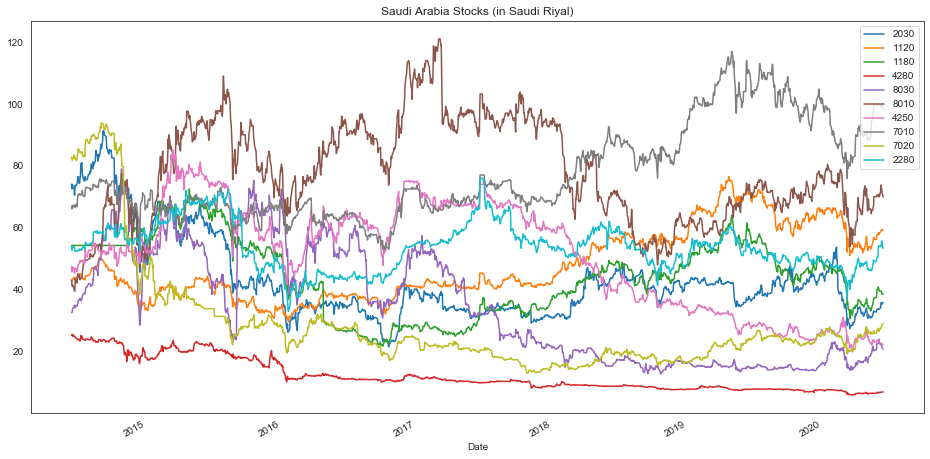

In [39]:
# Plot the Stock Price Movements of Saudi Arabia Stocks in Saudi Riyal
stockDFClose[2030].plot(label='2030', figsize = (16,8))
stockDFClose[1120].plot(label='1120')
stockDFClose[1180].plot(label='1180')
stockDFClose[4280].plot(label='4280')
stockDFClose[8030].plot(label='8030')
stockDFClose[8010].plot(label='8010')
stockDFClose[4250].plot(label='4250')
stockDFClose[7010].plot(label='7010')
stockDFClose[7020].plot(label='7020')
stockDFClose[2280].plot(label='2280')
plt.title('Saudi Arabia Stocks (in Saudi Riyal)')
plt.legend();

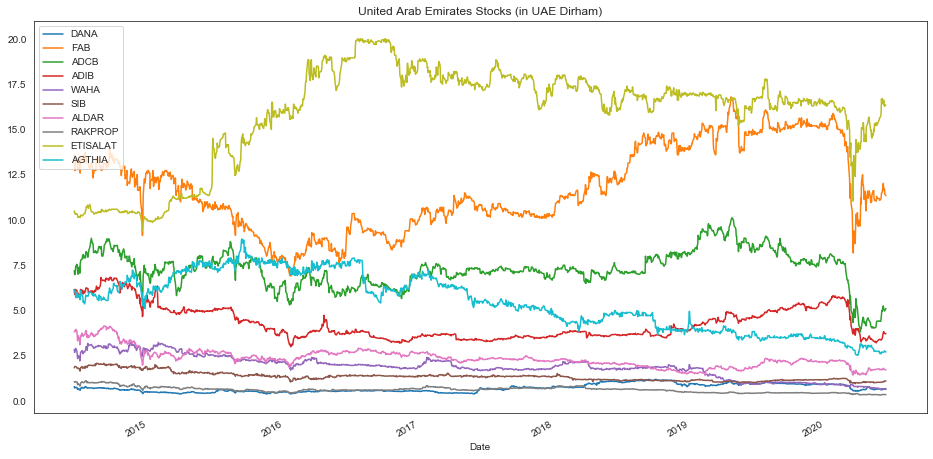

In [40]:
# Plot the Stock Price Movements of United Arab Emirates Stocks in UAE Dirham
stockDFClose['DANA'].plot(label='DANA', figsize = (16,8))
stockDFClose['FAB'].plot(label='FAB')
stockDFClose['ADCB'].plot(label='ADCB')
stockDFClose['ADIB'].plot(label='ADIB')
stockDFClose['WAHA'].plot(label='WAHA')
stockDFClose['SIB'].plot(label='SIB')
stockDFClose['ALDAR'].plot(label='ALDAR')
stockDFClose['RAKPROP'].plot(label='RAKPROP')
stockDFClose['ETISALAT'].plot(label='ETISALAT')
stockDFClose['AGTHIA'].plot(label='AGTHIA')
plt.title('United Arab Emirates Stocks (in UAE Dirham)')
plt.legend();

### Plot the Stock Price Movements by Sector

In [41]:
# Make a copy of stockDFClose Dataframe into stockDFCloseUSD Dataframe for Base Currency (USD) Conversion using the following exchange rates
stockDFCloseUSD = stockDFClose.copy()

# Exchange Rate are as follows:
# 1 Kuwaiti Dinar = 3.29 USD
# 1 Omani Rial = 2.60 USD
# 1 Qatari Rial = 0.27 USD
# 1 Saudi Arabia = 0.27 USD
# 1 UAE Dirham = 0.27 USD

# Conversion to USD Base Currency
stockDFCloseUSD['GPIK'] = stockDFCloseUSD['GPIK'] * 3.29
stockDFCloseUSD['GBKK'] = stockDFCloseUSD['GBKK'] * 3.29
stockDFCloseUSD['BOUK'] = stockDFCloseUSD['BOUK'] * 3.29
stockDFCloseUSD['KFH'] = stockDFCloseUSD['KFH'] * 3.29
stockDFCloseUSD['NBKK'] = stockDFCloseUSD['NBKK'] * 3.29
stockDFCloseUSD['BURG'] = stockDFCloseUSD['BURG'] * 3.29
stockDFCloseUSD['HUMN'] = stockDFCloseUSD['HUMN'] * 3.29
stockDFCloseUSD['MABK'] = stockDFCloseUSD['MABK'] * 3.29
stockDFCloseUSD['ZAIN'] = stockDFCloseUSD['ZAIN'] * 3.29
stockDFCloseUSD['CATT'] = stockDFCloseUSD['CATT'] * 3.29

stockDFCloseUSD['RNSS'] = stockDFCloseUSD['RNSS'] * 2.60
stockDFCloseUSD['BKMB'] = stockDFCloseUSD['BKMB'] * 2.60
stockDFCloseUSD['ABOB'] = stockDFCloseUSD['ABOB'] * 2.60
stockDFCloseUSD['BKSB'] = stockDFCloseUSD['BKSB'] * 2.60
stockDFCloseUSD['HBMO'] = stockDFCloseUSD['HBMO'] * 2.60
stockDFCloseUSD['AAIT'] = stockDFCloseUSD['AAIT'] * 2.60
stockDFCloseUSD['OTEL'] = stockDFCloseUSD['OTEL'] * 2.60
stockDFCloseUSD['SIHC'] = stockDFCloseUSD['SIHC'] * 2.60
stockDFCloseUSD['OIFC'] = stockDFCloseUSD['OIFC'] * 2.60
stockDFCloseUSD['OFCI'] = stockDFCloseUSD['OFCI'] * 2.60

stockDFCloseUSD['QFLS'] = stockDFCloseUSD['QFLS'] * 0.27
stockDFCloseUSD['QNBK'] = stockDFCloseUSD['QNBK'] * 0.27
stockDFCloseUSD['QINS'] = stockDFCloseUSD['QINS'] * 0.27
stockDFCloseUSD['COMB'] = stockDFCloseUSD['COMB'] * 0.27
stockDFCloseUSD['QISB'] = stockDFCloseUSD['QISB'] * 0.27
stockDFCloseUSD['IHGS'] = stockDFCloseUSD['IHGS'] * 0.27
stockDFCloseUSD['ERES'] = stockDFCloseUSD['ERES'] * 0.27
stockDFCloseUSD['BRES'] = stockDFCloseUSD['BRES'] * 0.27
stockDFCloseUSD['ORDS'] = stockDFCloseUSD['ORDS'] * 0.27
stockDFCloseUSD['MERS'] = stockDFCloseUSD['MERS'] * 0.27

stockDFCloseUSD[2030] = stockDFCloseUSD[2030] * 0.27
stockDFCloseUSD[1120] = stockDFCloseUSD[1120] * 0.27
stockDFCloseUSD[1180] = stockDFCloseUSD[1180] * 0.27
stockDFCloseUSD[4280] = stockDFCloseUSD[4280] * 0.27
stockDFCloseUSD[8030] = stockDFCloseUSD[8030] * 0.27
stockDFCloseUSD[8010] = stockDFCloseUSD[8010] * 0.27
stockDFCloseUSD[4250] = stockDFCloseUSD[4250] * 0.27
stockDFCloseUSD[7010] = stockDFCloseUSD[7010] * 0.27
stockDFCloseUSD[7020] = stockDFCloseUSD[7020] * 0.27
stockDFCloseUSD[2280] = stockDFCloseUSD[2280] * 0.27

stockDFCloseUSD['DANA'] = stockDFCloseUSD['DANA'] * 0.27
stockDFCloseUSD['FAB'] = stockDFCloseUSD['FAB'] * 0.27
stockDFCloseUSD['ADCB'] = stockDFCloseUSD['ADCB'] * 0.27
stockDFCloseUSD['ADIB'] = stockDFCloseUSD['ADIB'] * 0.27
stockDFCloseUSD['WAHA'] = stockDFCloseUSD['WAHA'] * 0.27
stockDFCloseUSD['SIB'] = stockDFCloseUSD['SIB'] * 0.27
stockDFCloseUSD['ALDAR'] = stockDFCloseUSD['ALDAR'] * 0.27
stockDFCloseUSD['RAKPROP'] = stockDFCloseUSD['RAKPROP'] * 0.27
stockDFCloseUSD['ETISALAT'] = stockDFCloseUSD['ETISALAT'] * 0.27
stockDFCloseUSD['AGTHIA'] = stockDFCloseUSD['AGTHIA'] * 0.27

# Display the Top 5 Observations to confirm that the stockDFCloseUSD Data Frame is structured properly
stockDFCloseUSD.head()

Symbol         1120     1180     2030     2280    4250   4280     7010     7020    8010   8030    AAIT    ABOB    ADCB    ADIB  AGTHIA   ALDAR    BKMB    BKSB     BOUK     BRES     BURG    CATT     COMB    DANA     ERES  ETISALAT     FAB     GBKK     GPIK    HBMO     HUMN     IHGS      KFH     MABK    MERS     NBKK    OFCI    OIFC    ORDS   OTEL     QFLS     QINS    QISB     QNBK  RAKPROP    RNSS     SIB    SIHC    WAHA    ZAIN
Date                                                                                                                                                                                                                                                                                                                                                                                                                                           
2014-06-15  11.6559  14.6475  19.9800  14.5800  12.798  6.858  18.0900  22.3425  11.583  8.775  0.7202  0.4212  1.9440  1.6632  1.6551  1.0422  1.5652  0.5772  1552.88  1.10025  1674.61  783.02  1.45584  0.2133  0.59940    2.8350  3.5964  1049.51  250.698  0.4108  1092.28  1.70802  2148.37  2832.69  4.8411  2826.11  0.2314  0.7852  3.8853  4.160  4.91967  1.20420  2.5920  3.68604   0.2862  1.6952  0.4941  0.5980  0.7668  2171.4
2014-06-16  11.4750  14.6475  19.5750  14.2263  12.339  6.858  17.8200  22.2075  11.286  8.802  0.7124  0.4212  1.8873  1.5876  1.6551  1.0314  1.5938  0.5850  1552.88  1.05840  1707.51  783.02  1.46043  0.1944  0.58914    2.7972  3.6693  1082.41  247.408  0.4108  1092.28  1.67103  2122.05  2888.62  4.6170  2855.72  0.2340  0.7904  3.8610  4.173  4.86243  1.16802  2.5380  3.62448   0.2781  1.6952  0.5130  0.6110  0.7236  2138.5
2014-06-17  11.5857  14.6475  19.9800  14.4288  12.555  6.750  17.8875  22.0725  11.097  8.883  0.7124  0.4134  1.8846  1.6335  1.6200  1.0314  1.5860  0.5876  1523.27  1.05300  1645.00  783.02  1.45584  0.2025  0.58590    2.7972  3.4371  1082.41  244.447  0.4082  1092.28  1.68480  2092.44  2832.69  4.5360  2826.11  0.2392  0.7852  3.6720  4.147  4.93344  1.15911  2.5191  3.62448   0.2862  1.6952  0.5130  0.6032  0.7641  2138.5
2014-06-18  11.6748  14.6475  19.9125  14.5287  12.771  6.885  17.9550  22.1400  11.178  9.153  0.7124  0.4238  1.9575  1.6632  1.6200  1.0449  1.5756  0.5850  1523.27  1.04895  1645.00  783.02  1.46043  0.1998  0.58050    2.7864  3.5829  1049.51  234.906  0.4082  1092.28  1.66401  2066.12  2888.62  4.5360  2826.11  0.2392  0.7956  3.5937  4.173  4.96800  1.15749  2.5110  3.74328   0.2862  1.6952  0.5130  0.6162  0.7722  2105.6
2014-06-19  11.7612  14.6475  19.7775  14.4774  12.717  6.750  18.1575  22.3425  11.124  9.207  0.7150  0.4238  2.0088  1.6524  1.5390  1.0665  1.6042  0.5850  1523.27  1.04490  1612.10  783.02  1.47393  0.2025  0.58644    2.7972  3.6207  1065.96  231.945  0.4108  1105.44  1.66644  2066.12  2832.69  4.5603  2826.11  0.2418  0.7904  3.5100  4.173  4.92669  1.20420  2.4732  3.59991   0.2862  1.6744  0.5130  0.6110  0.7830  2105.6

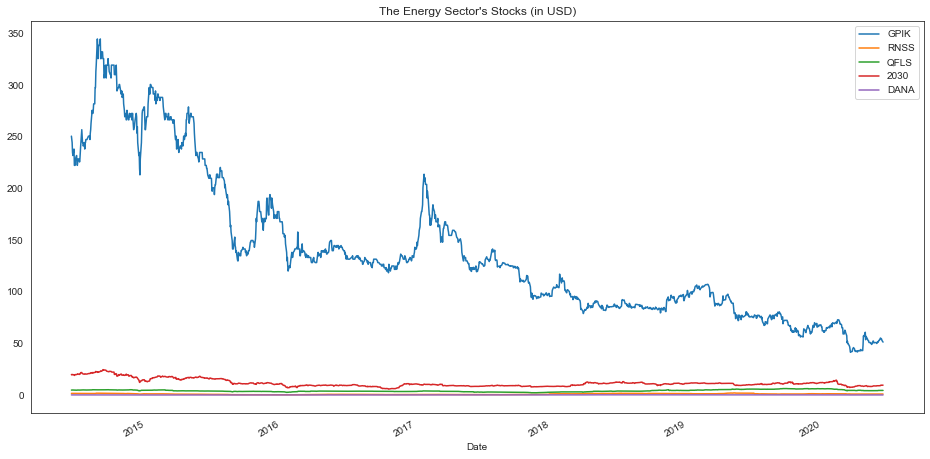

In [42]:
# Plot the Stock Price Movements of the Energy Sector's Stocks in USD 
stockDFCloseUSD['GPIK'].plot(label='GPIK', figsize = (16,8))
stockDFCloseUSD['RNSS'].plot(label='RNSS')
stockDFCloseUSD['QFLS'].plot(label='QFLS')
stockDFCloseUSD[2030].plot(label='2030')
stockDFCloseUSD['DANA'].plot(label='DANA')
plt.title('The Energy Sector\'s Stocks (in USD)')
plt.legend();

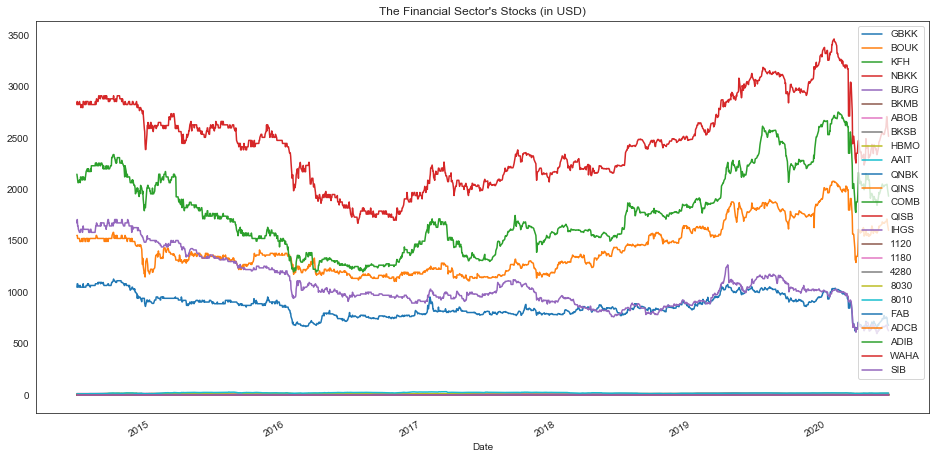

In [43]:
# Plot the Stock Price Movements of the Financial Sector's Stocks in USD
stockDFCloseUSD['GBKK'].plot(label='GBKK', figsize = (16,8))
stockDFCloseUSD['BOUK'].plot(label='BOUK')
stockDFCloseUSD['KFH'].plot(label='KFH')
stockDFCloseUSD['NBKK'].plot(label='NBKK')
stockDFCloseUSD['BURG'].plot(label='BURG')
stockDFCloseUSD['BKMB'].plot(label='BKMB')
stockDFCloseUSD['ABOB'].plot(label='ABOB')
stockDFCloseUSD['BKSB'].plot(label='BKSB')
stockDFCloseUSD['HBMO'].plot(label='HBMO')
stockDFCloseUSD['AAIT'].plot(label='AAIT')
stockDFCloseUSD['QNBK'].plot(label='QNBK')
stockDFCloseUSD['QINS'].plot(label='QINS')
stockDFCloseUSD['COMB'].plot(label='COMB')
stockDFCloseUSD['QISB'].plot(label='QISB')
stockDFCloseUSD['IHGS'].plot(label='IHGS')
stockDFCloseUSD[1120].plot(label='1120')
stockDFCloseUSD[1180].plot(label='1180')
stockDFCloseUSD[4280].plot(label='4280')
stockDFCloseUSD[8030].plot(label='8030')
stockDFCloseUSD[8010].plot(label='8010')
stockDFCloseUSD['FAB'].plot(label='FAB')
stockDFCloseUSD['ADCB'].plot(label='ADCB')
stockDFCloseUSD['ADIB'].plot(label='ADIB')
stockDFCloseUSD['WAHA'].plot(label='WAHA')
stockDFCloseUSD['SIB'].plot(label='SIB')
plt.title('The Financial Sector\'s Stocks (in USD)')
plt.legend();

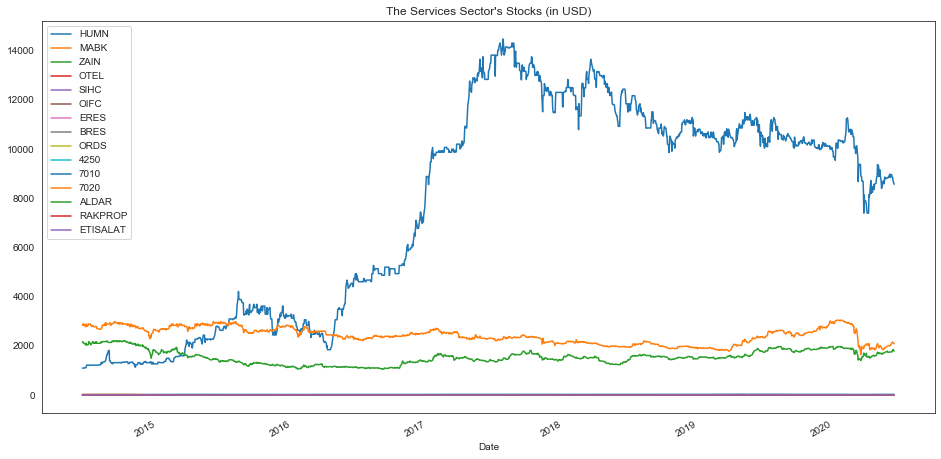

In [44]:
# Plot the Stock Price Movements of the Services Sector's Stocks in USD
stockDFCloseUSD['HUMN'].plot(label='HUMN', figsize = (16,8))
stockDFCloseUSD['MABK'].plot(label='MABK')
stockDFCloseUSD['ZAIN'].plot(label='ZAIN')
stockDFCloseUSD['OTEL'].plot(label='OTEL')
stockDFCloseUSD['SIHC'].plot(label='SIHC')
stockDFCloseUSD['OIFC'].plot(label='OIFC')
stockDFCloseUSD['ERES'].plot(label='ERES')
stockDFCloseUSD['BRES'].plot(label='BRES')
stockDFCloseUSD['ORDS'].plot(label='ORDS')
stockDFCloseUSD[4250].plot(label='4250')
stockDFCloseUSD[7010].plot(label='7010')
stockDFCloseUSD[7020].plot(label='7020')
stockDFCloseUSD['ALDAR'].plot(label='ALDAR')
stockDFCloseUSD['RAKPROP'].plot(label='RAKPROP')
stockDFCloseUSD['ETISALAT'].plot(label='ETISALAT')
plt.title('The Services Sector\'s Stocks (in USD)')
plt.legend();

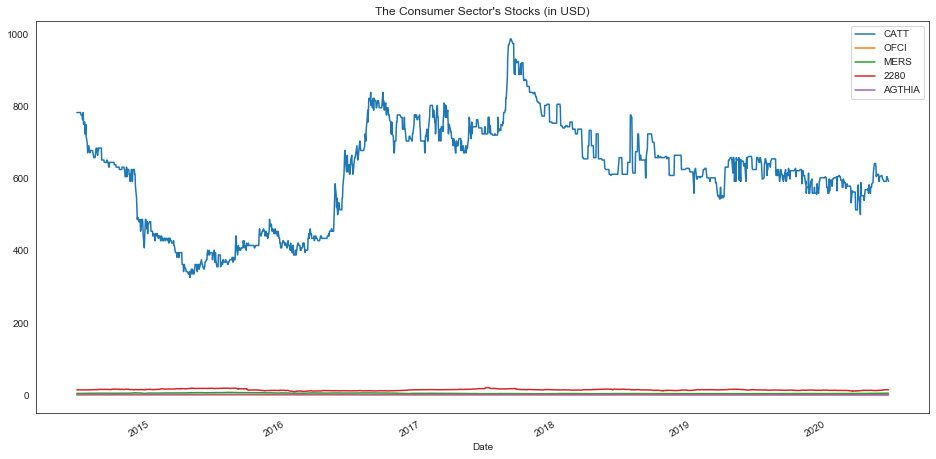

In [45]:
# Plot the Stock Price Movements of the Consumer Sector's Stocks in USD
stockDFCloseUSD['CATT'].plot(label='CATT', figsize = (16,8))
stockDFCloseUSD['OFCI'].plot(label='OFCI')
stockDFCloseUSD['MERS'].plot(label='MERS')
stockDFCloseUSD[2280].plot(label='2280')
stockDFCloseUSD['AGTHIA'].plot(label='AGTHIA')
plt.title('The Consumer Sector\'s Stocks (in USD)')
plt.legend();

## **Final Hypotheses**

With the preliminary review of the dataset, data preprocessing, and exploratory data analysis, the initial hypotheses will be considered and validated. The hypotheses for this machine learning project are as follows:<br/>
H1: Grouping stocks of similar behaviour based on Technical Trading Indicators will optimise and diversify an investment portfolio.<br/>
H2: Historical Stock Information and Technical Trading Indicators are vital features to predict stock performance.

### Descriptive Model
The objective of the descriptive model of this machine learning project is to provide the investors with the optimal portfolio mix to maximise return and minimise risk. <br/><br/>
The K-Means algorithm is considered in this case based on the inference from the literature review that postulates that the K-Means tends to perform better than its alternatives, in terms of scalability and efficiency, especially for stocks' classification. The unsupervised classification observes the similarity of the shares based on the stock movement leveraging the stocks' volatility and return.<br/><br/>
The Self Organising Map (SOM) Artificial Neural Network is also considered to benchmark the outcome of the K-Means Algorithm. The unsupervised deep learning technique reduces high dimensional data to map by grouping similar data together using the concept of Euclidean Distance to calculate the best matching unit based on an initialised weight with several iterations. The neural network will also be applied on the stock movement data.

In [46]:
# Review the stockDFClose Data Frame
stockDFClose.head()

Symbol       1120   1180   2030   2280  4250  4280   7010   7020  8010  8030   AAIT   ABOB  ADCB  ADIB  AGTHIA  ALDAR   BKMB   BKSB   BOUK   BRES   BURG   CATT   COMB  DANA   ERES  ETISALAT    FAB   GBKK  GPIK   HBMO   HUMN   IHGS    KFH   MABK   MERS   NBKK   OFCI   OIFC   ORDS   OTEL    QFLS   QINS  QISB    QNBK  RAKPROP   RNSS   SIB   SIHC  WAHA   ZAIN
Date                                                                                                                                                                                                                                                                                                                                                                 
2014-06-15  43.17  54.25  74.00  54.00  47.4  25.4  67.00  82.75  42.9  32.5  0.277  0.162  7.20  6.16    6.13   3.86  0.602  0.222  472.0  4.075  509.0  238.0  5.392  0.79  2.220     10.50  13.32  319.0  76.2  0.158  332.0  6.326  653.0  861.0  17.93  859.0  0.089  0.302  14.39  1.600  18.221  4.460  9.60  13.652     1.06  0.652  1.83  0.230  2.84  660.0
2014-06-16  42.50  54.25  72.50  52.69  45.7  25.4  66.00  82.25  41.8  32.6  0.274  0.162  6.99  5.88    6.13   3.82  0.613  0.225  472.0  3.920  519.0  238.0  5.409  0.72  2.182     10.36  13.59  329.0  75.2  0.158  332.0  6.189  645.0  878.0  17.10  868.0  0.090  0.304  14.30  1.605  18.009  4.326  9.40  13.424     1.03  0.652  1.90  0.235  2.68  650.0
2014-06-17  42.91  54.25  74.00  53.44  46.5  25.0  66.25  81.75  41.1  32.9  0.274  0.159  6.98  6.05    6.00   3.82  0.610  0.226  463.0  3.900  500.0  238.0  5.392  0.75  2.170     10.36  12.73  329.0  74.3  0.157  332.0  6.240  636.0  861.0  16.80  859.0  0.092  0.302  13.60  1.595  18.272  4.293  9.33  13.424     1.06  0.652  1.90  0.232  2.83  650.0
2014-06-18  43.24  54.25  73.75  53.81  47.3  25.5  66.50  82.00  41.4  33.9  0.274  0.163  7.25  6.16    6.00   3.87  0.606  0.225  463.0  3.885  500.0  238.0  5.409  0.74  2.150     10.32  13.27  319.0  71.4  0.157  332.0  6.163  628.0  878.0  16.80  859.0  0.092  0.306  13.31  1.605  18.400  4.287  9.30  13.864     1.06  0.652  1.90  0.237  2.86  640.0
2014-06-19  43.56  54.25  73.25  53.62  47.1  25.0  67.25  82.75  41.2  34.1  0.275  0.163  7.44  6.12    5.70   3.95  0.617  0.225  463.0  3.870  490.0  238.0  5.459  0.75  2.172     10.36  13.41  324.0  70.5  0.158  336.0  6.172  628.0  861.0  16.89  859.0  0.093  0.304  13.00  1.605  18.247  4.460  9.16  13.333     1.06  0.644  1.90  0.235  2.90  640.0

In [47]:
# Review the summary of the stockDFClose Data Frame
stockDFClose.describe()

Symbol         1120         1180         2030         2280         4250         4280         7010         7020         8010         8030         AAIT         ABOB         ADCB         ADIB       AGTHIA        ALDAR         BKMB         BKSB         BOUK         BRES         BURG         CATT         COMB         DANA         ERES     ETISALAT          FAB         GBKK         GPIK         HBMO         HUMN         IHGS          KFH         MABK         MERS         NBKK         OFCI         OIFC         ORDS         OTEL         QFLS         QINS         QISB         QNBK      RAKPROP         RNSS          SIB         SIHC         WAHA         ZAIN
count   1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000  1533.000000
mean      47.663575    44.330117    43.091977    53.792720    50.995806    12.133085    77.387606    28.308200    77.954566    34.428089     0.146444     0.162001     7.283568     4.295868     5.473823     2.358089     0.415718     0.138139   431.015003     3.707457   327.612524   186.330724     4.144641     0.706661     1.327463    15.878265    11.743275   263.635356    42.114938     0.121611  2337.642531     5.495218   541.259622   734.414220    17.725300   744.149380     0.084468     0.161256     8.681992     1.199642    15.545109     4.735471    11.935233    15.471040     0.619596     0.400556     1.346576     0.116746     1.892901   469.493803
std       11.305924    12.304038    13.499572     7.530279    16.819220     5.234482    14.894573    17.180265    16.246787    18.221843     0.051533     0.031695     1.027610     0.901560     1.561707     0.506234     0.086364     0.035499    71.429934     0.569845    75.704204    41.917653     0.941640     0.217016     0.458462     2.721653     2.305596    32.092811    21.286202     0.017677  1309.704019     3.464781   116.479855    99.923574     3.503773   122.484439     0.030822     0.055822     1.882679     0.436124     3.627315     1.304847     2.493352     2.508783     0.154315     0.178202     0.247833     0.034788     0.617666    85.561527
min       29.480000    21.730000    21.500000    33.000000    19.800000     5.900000    52.750000    13.000000    39.500000    12.680000     0.060000     0.105000     3.820000     3.000000     2.520000     1.430000     0.302000     0.077000   336.000000     2.600000   182.000000    99.000000     2.575000     0.380000     0.462000     9.410000     6.900000   187.000000    12.600000     0.086000   332.000000     1.271000   364.000000   498.000000    13.000000   508.000000     0.042000     0.076000     5.097000     0.520000     8.480000     1.970000     7.730000    11.136000     0.327000     0.110000     0.951000     0.058000     0.628000   320.000000
25%       39.400000    34.000000    34.000000    48.300000    35.000000     8.250000    66.500000    19.220000    66.800000    16.440000     0.100000     0.137000     6.800000     3.590000     3.950000     2.080000     0.357000     0.113000   371.000000     3.350000   279.000000   156.000000     3.341000     0.530000     0.931000    15.100000    10.150000   240.000000    26.100000     0.112000   940.000000     2.450000   455.000000   647.000000    14.970000   656.000000     0.060000     0.112000     7.140000     0.732000    13.200000     3.595000    10.020000    13.561000     0.480000     0.225000     1.162000     0.091000     1.710000   410.000000
50%       42.950000    45.200000    40.000000    53.800000

In [48]:
# Calculate the average annual percentage of the stock returns as well as the volatility of the stocks over an average of 250 market trading days in the Middle East per year
stockReturns = stockDFClose.pct_change().mean() * 250
stockReturns = pd.DataFrame(stockReturns)
stockReturns.columns = ['Returns']
stockReturns['Volatility'] = stockDFClose.pct_change().std() * sqrt(250)
stockReturns

Returns  Volatility
Symbol                        
1120      0.078562    0.232623
1180     -0.009711    0.297499
2030     -0.046288    0.378432
2280      0.038610    0.283773
4250     -0.070664    0.324907
4280     -0.168590    0.295826
7010      0.091432    0.239429
7020     -0.108703    0.352143
8010      0.161475    0.402546
8030      0.159176    0.809375
AAIT     -0.137737    0.377001
ABOB     -0.014925    0.261026
ADCB      0.001130    0.339315
ADIB     -0.046530    0.269004
AGTHIA   -0.064821    0.371847
ALDAR    -0.073603    0.344499
BKMB     -0.069614    0.217135
BKSB     -0.123445    0.278058
BOUK      0.030955    0.226438
BRES     -0.010942    0.296317
BURG     -0.133353    0.233314
CATT      0.048273    0.435292
COMB     -0.017927    0.267322
DANA      0.060864    0.440178
ERES     -0.055772    0.420198
ETISALAT  0.096657    0.222504
FAB       0.024990    0.321473
GBKK     -0.042425    0.239771
GPIK     -0.181448    0.393810
HBMO     -0.046680    0.275097
HUMN      0.423346    0.415874
IHGS     -0.034009    0.458567
KFH       0.011669    0.238715
MABK     -0.019120    0.246934
MERS      0.038170    0.234963
NBKK      0.004632    0.215362
OFCI      0.091945    0.404856
OIFC     -0.157181    0.332667
ORDS     -0.081013    0.299555
OTEL     -0.123868    0.217034
QFLS      0.017308    0.245770
QINS     -0.079856    0.312763
QISB      0.118657    0.252363
QNBK      0.070387    0.240817
RAKPROP  -0.108067    0.378549
RNSS      0.024088    0.461982
SIB      -0.032712    0.317319
SIHC     -0.117808    0.403345
WAHA     -0.163728    0.367329
ZAIN      0.001593    0.257953

In [49]:
# The Returns and Volatility values are within a reasonable range and as such do not require normalisation or standardisation.
# Convert the stockReturns Dataframe to numpy array and transpose the array to a return and volatility pair for the K-Means Clustering Algorithm
stockX = np.asarray([np.asarray(stockReturns['Returns']),np.asarray(stockReturns['Volatility'])]).T

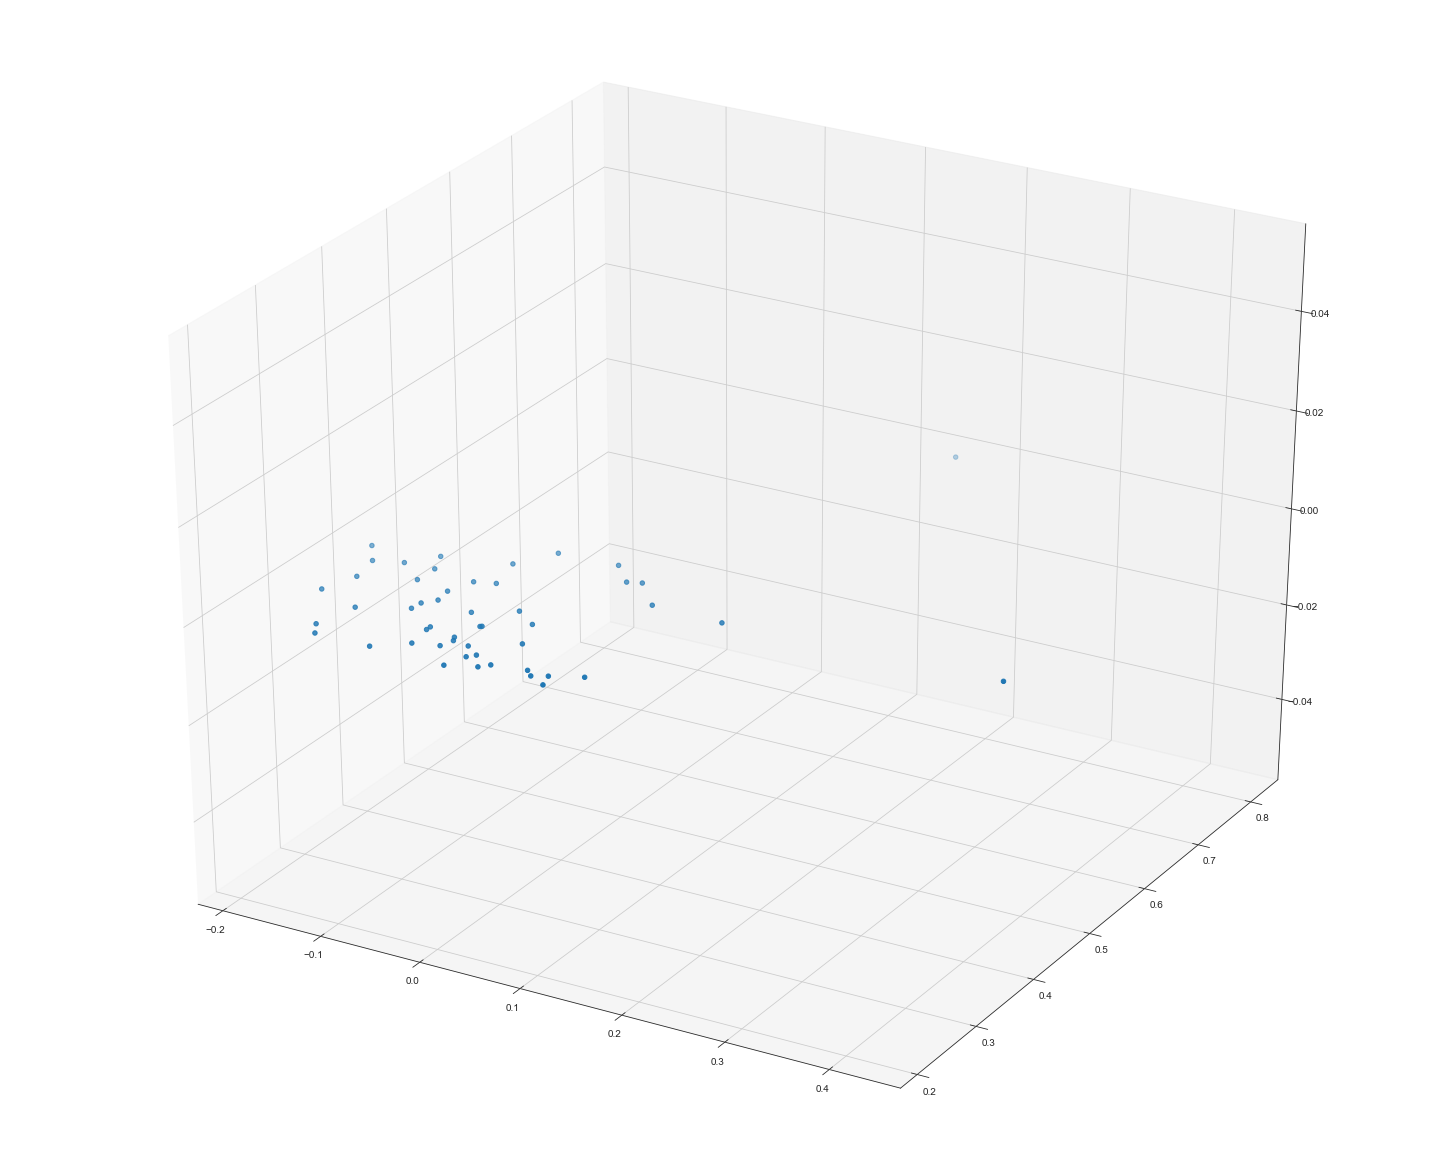

In [50]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(stockX[:,0], stockX[:,1])

### K-Means

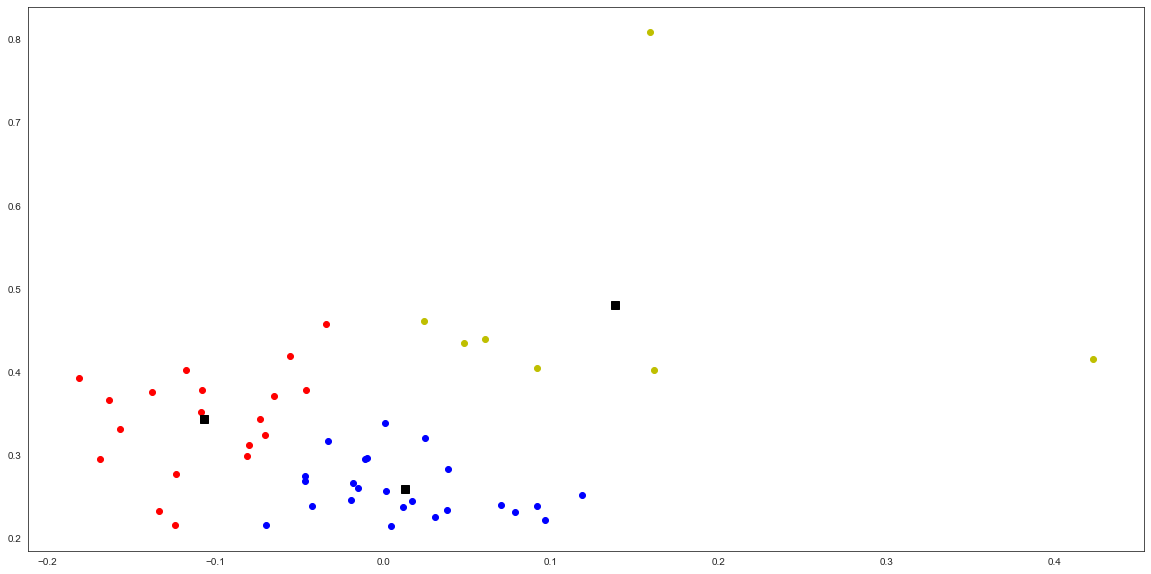

In [51]:
# Execute the K-Means Algorithm with the random clusters' value of K=3
centroids,_ = kmeans(stockX,3)

# Assign each of the stock to a cluster
idx,_ = vq(stockX,centroids)

# Plot the cluster indices of each of the stock using the logical indexing from numpy
plt.figure(figsize=(20,10))
plt.plot(stockX[idx==0,0],stockX[idx==0,1],'ob',
     stockX[idx==1,0],stockX[idx==1,1],'oy',
     stockX[idx==2,0],stockX[idx==2,1],'or')
plt.plot(centroids[:,0],centroids[:,1],'sk', markersize=8)
plt.show()

In [52]:
# Print out the stocks with the clusters they belong based on the K-Means Algorithm
stockClusters = [(name,cluster) for name, cluster in zip(stockReturns.index,idx)]

for stockPoint in stockClusters:
    print(stockPoint)

(1120, 0)
(1180, 0)
(2030, 2)
(2280, 0)
(4250, 2)
(4280, 2)
(7010, 0)
(7020, 2)
(8010, 1)
(8030, 1)
('AAIT', 2)
('ABOB', 0)
('ADCB', 0)
('ADIB', 0)
('AGTHIA', 2)
('ALDAR', 2)
('BKMB', 0)
('BKSB', 2)
('BOUK', 0)
('BRES', 0)
('BURG', 2)
('CATT', 1)
('COMB', 0)
('DANA', 1)
('ERES', 2)
('ETISALAT', 0)
('FAB', 0)
('GBKK', 0)
('GPIK', 2)
('HBMO', 0)
('HUMN', 1)
('IHGS', 2)
('KFH', 0)
('MABK', 0)
('MERS', 0)
('NBKK', 0)
('OFCI', 1)
('OIFC', 2)
('ORDS', 2)
('OTEL', 2)
('QFLS', 0)
('QINS', 2)
('QISB', 0)
('QNBK', 0)
('RAKPROP', 2)
('RNSS', 1)
('SIB', 0)
('SIHC', 2)
('WAHA', 2)
('ZAIN', 0)


<table border="0" cellpadding="0" cellspacing="0" width="100%">
        <tbody>
          <tr>
            <td>Clusters </td>
            <td>Stock Symbol </td>
            <td>Stock Exchange</td>
            <td>Sector</td>
          </tr>
          <tr>
            <td>0</td>
            <td>2030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>0</td>
            <td>4250</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>4280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>7020</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>AAIT</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>AGTHIA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>0</td>
            <td>ALDAR</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>BKSB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>BURG</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>ERES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>GPIK</td>
            <td>Kuwait Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>0</td>
            <td>IHGS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>OIFC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>ORDS</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>OTEL</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>QINS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>RAKPROP</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>SIHC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>WAHA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>1120</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>1180</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>2280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>1</td>
            <td>7010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ABOB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ADCB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ADIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>BKMB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>BOUK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>BRES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>COMB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ETISALAT</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>FAB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>GBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>HBMO</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>KFH</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>MABK</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>MERS</td>
            <td>Qatar Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>1</td>
            <td>NBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>QFLS</td>
            <td>Qatar Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>1</td>
            <td>QISB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>QNBK</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>SIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ZAIN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>8010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>2</td>
            <td>8030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>2</td>
            <td>CATT</td>
            <td>Kuwait Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>2</td>
            <td>DANA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>2</td>
            <td>HUMN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>OFCI</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>2</td>
            <td>RNSS</td>
            <td>Muscat Securities    Market</td>
            <td>ENERGY</td>
          </tr>
        </tbody>
    </table>

The K-Means Algorithm (with the random K=3) grouped about half (24/50) of the stocks in Cluster Group-1 based on their similarity in movement and pattern as regards to their returns and volatility. Albeit, the stocks in Cluster Group-1 are more volatile than the others, but they are mainly with low volatility which means their stock price does not change frequently and a sizable number of them are reporting positive returns. The Cluster Group-0 has 19 member stocks that are mainly reporting negative returns with a reasonable level of volatility. All of the stocks reporting positive returns are in the Cluster Group-2 with some of them highly volatile. The stocks in Cluster Group-1 are good candidates for risk-averse investors while the risk-taker investors can benefit from the stocks in Group-2. The outcome of the K-Means Technique in classifying the stocks into district groups is reasonable but will be turned to ensure the optimised K is used.

### Self Organising Map (SOM)

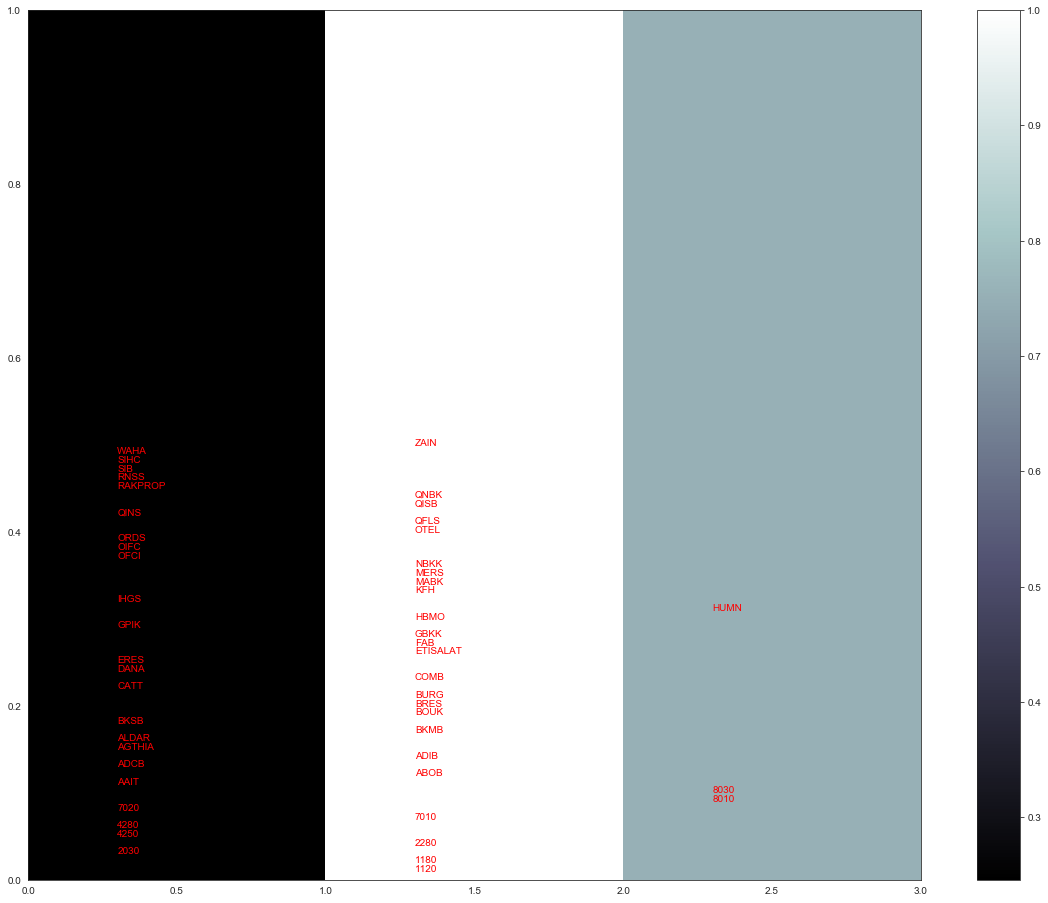

In [53]:
# Execute the Self Organising Map (SOM) ANN with the 3 by 1 map
som = MiniSom(x = 3, y = 1, input_len = 2, sigma = 0.2, learning_rate = 0.5)
som.random_weights_init(stockX)
som.train_random(data = stockX, num_iteration = 100)
bone()
pcolor(som.distance_map().T)
colorbar()
posY = 0.01
for i, x in enumerate(stockX):
    w = som.winner(x)
    plt.text(w[0] + 0.3 , w[1] + posY, stockReturns.index[i], fontsize=10, color='red')
    posY = posY + 0.01
show()

In [54]:
# Print out the SOM array for the stocks and positioning on the map
som.win_map(stockX)

defaultdict(list,
            {(1, 0): [array([0.07856221, 0.23262349]),
              array([-0.00971065,  0.29749876]),
              array([0.03860987, 0.28377344]),
              array([0.09143235, 0.23942892]),
              array([-0.01492538,  0.26102569]),
              array([-0.04652993,  0.26900374]),
              array([-0.06961391,  0.21713493]),
              array([0.03095451, 0.22643831]),
              array([-0.01094249,  0.29631713]),
              array([-0.13335325,  0.23331385]),
              array([-0.01792679,  0.26732194]),
              array([0.0966575 , 0.22250449]),
              array([0.0249899 , 0.32147272]),
              array([-0.04242467,  0.23977123]),
              array([-0.04668042,  0.27509712]),
              array([0.01166913, 0.23871494]),
              array([-0.01911994,  0.24693446]),
              array([0.03816963, 0.23496322]),
              array([0.00463183, 0.21536228]),
              array([-0.12386825,  0.21703358]),
            

In [55]:
# Collect the Best Matching Unit (BMU) of all the stocks in the map
stockList = []
for i, x in enumerate(stockX):
    idW = str(som.winner(x))
    stockList.append(idW)
    
# Print out the stocks with the clusters they belong based on the SOM Neural Network
stockClusters = [(name,cluster) for name, cluster in zip(stockReturns.index,stockList)]

for stockPoint in stockClusters:
    print(stockPoint)

(1120, '(1, 0)')
(1180, '(1, 0)')
(2030, '(0, 0)')
(2280, '(1, 0)')
(4250, '(0, 0)')
(4280, '(0, 0)')
(7010, '(1, 0)')
(7020, '(0, 0)')
(8010, '(2, 0)')
(8030, '(2, 0)')
('AAIT', '(0, 0)')
('ABOB', '(1, 0)')
('ADCB', '(0, 0)')
('ADIB', '(1, 0)')
('AGTHIA', '(0, 0)')
('ALDAR', '(0, 0)')
('BKMB', '(1, 0)')
('BKSB', '(0, 0)')
('BOUK', '(1, 0)')
('BRES', '(1, 0)')
('BURG', '(1, 0)')
('CATT', '(0, 0)')
('COMB', '(1, 0)')
('DANA', '(0, 0)')
('ERES', '(0, 0)')
('ETISALAT', '(1, 0)')
('FAB', '(1, 0)')
('GBKK', '(1, 0)')
('GPIK', '(0, 0)')
('HBMO', '(1, 0)')
('HUMN', '(2, 0)')
('IHGS', '(0, 0)')
('KFH', '(1, 0)')
('MABK', '(1, 0)')
('MERS', '(1, 0)')
('NBKK', '(1, 0)')
('OFCI', '(0, 0)')
('OIFC', '(0, 0)')
('ORDS', '(0, 0)')
('OTEL', '(1, 0)')
('QFLS', '(1, 0)')
('QINS', '(0, 0)')
('QISB', '(1, 0)')
('QNBK', '(1, 0)')
('RAKPROP', '(0, 0)')
('RNSS', '(0, 0)')
('SIB', '(0, 0)')
('SIHC', '(0, 0)')
('WAHA', '(0, 0)')
('ZAIN', '(1, 0)')


<table border="0" cellpadding="0" cellspacing="0" width="100%">
        <tbody>
          <tr>
            <td>Clusters </td>
            <td>Stock Symbol </td>
            <td>Stock Exchange</td>
            <td>Sector</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>8030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>HUMN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>1120</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>1180</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>2280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>4280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>7010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>ABOB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>ADIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>BKMB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>BKSB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>BOUK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>BRES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>BURG</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>COMB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>ETISALAT</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>FAB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>GBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>HBMO</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>KFH</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>MABK</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>MERS</td>
            <td>Qatar Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>NBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>ORDS</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>OTEL</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>QFLS</td>
            <td>Qatar Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>QINS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>QISB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>QNBK</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>SIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>ZAIN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>2030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>4250</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>7020</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>8010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>AAIT</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>ADCB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>AGTHIA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>ALDAR</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>CATT</td>
            <td>Kuwait Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>DANA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>ERES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>GPIK</td>
            <td>Kuwait Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>IHGS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>OFCI</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>OIFC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>RAKPROP</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>RNSS</td>
            <td>Muscat Securities    Market</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>SIHC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>WAHA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
        </tbody>
    </table>

The 3 x 1 Self Organising Map (SOM) also attempts to classify the stocks into three groups based on their similarity in stock volatility and return. There are several similarities in the groupings by the neural network when compared with the K-Mean Algorithm. For instance, HUMN and 8030, which are in a group in SOM are also grouped in Group-2 of the KMeans clustering. 

## Model Tuning: Descriptive Model
To enhance the performance of the K-Means clustering model. Four evaluation matrix will be deployed. These include the Elbow Curve, Silhouette index, Davies-Bouldin index, and Calinski-Harabasz index. These evaluation matrics tend to measure the clustering quality, tendency and identify the optimal K number for the K-Means such that the model minimises the sum of squared distance between the centroids of the clusters and the associated data points.

Text(0.5, 1.0, 'The Elbow Curve')

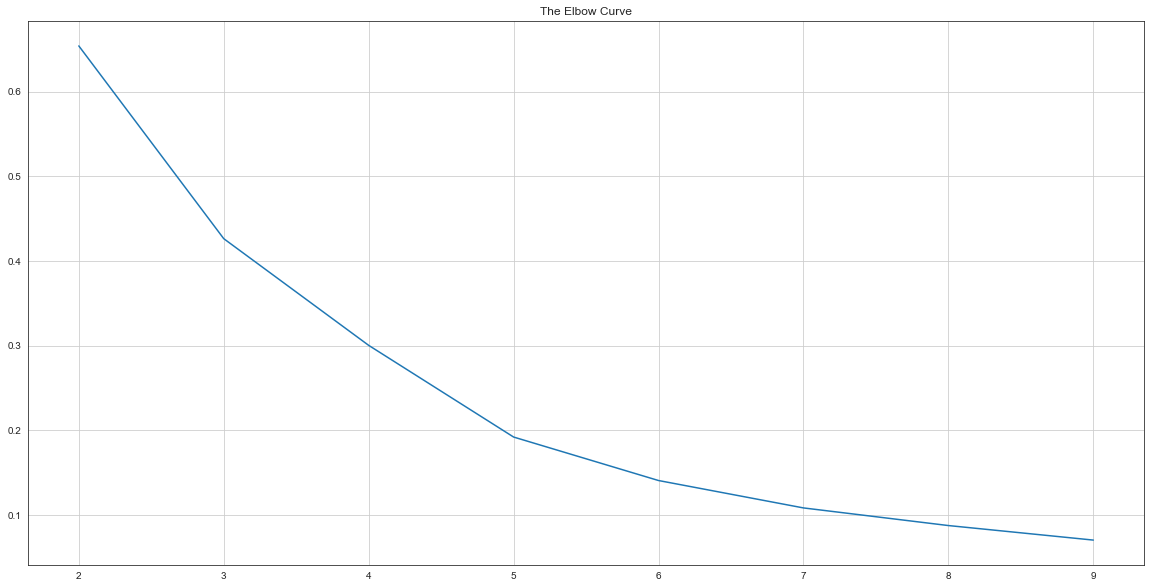

In [56]:
# Evaluation Matrix: Computing the Elbow Curve
# Run the K-Means Algorithm with a K range from 2 to 10 to review the index of the clusters data points
distorsions = []
for k in range(2, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(stockX)
    distorsions.append(k_means.inertia_)

# Plot the sum of squared distance (SSE) against the k value of K-Means
plt.figure(figsize=(20,10))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('The Elbow Curve')

In [57]:
# Evaluation Matrix: Computing the Silhouette Score
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_cluster in range_n_clusters:
    KMean= KMeans(n_clusters=n_cluster)
    KMean.fit(stockX)
    label=KMean.predict(stockX)
    print(f'Silhouette Score(n={n_cluster}): {silhouette_score(stockX, label)}')

Silhouette Score(n=2): 0.4997806283149941
Silhouette Score(n=3): 0.41344473538536924
Silhouette Score(n=4): 0.42204429515122593
Silhouette Score(n=5): 0.44167724734326635
Silhouette Score(n=6): 0.35460513701324287
Silhouette Score(n=7): 0.37535909772059173
Silhouette Score(n=8): 0.36329434228275664
Silhouette Score(n=9): 0.36090271306569505
Silhouette Score(n=10): 0.35666530958219334


In [58]:
# Evaluation Matrix: Computing the Davies Bouldin Score
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_cluster in range_n_clusters:
    KMean= KMeans(n_clusters=n_cluster)
    KMean.fit(stockX)
    label=KMean.predict(stockX)
    print(f'Davies Bouldin Score(n={n_cluster}): {davies_bouldin_score(stockX, label)}')

Davies Bouldin Score(n=2): 0.9569198672490202
Davies Bouldin Score(n=3): 0.822693166201613
Davies Bouldin Score(n=4): 0.6745230686642136
Davies Bouldin Score(n=5): 0.48926283070959775
Davies Bouldin Score(n=6): 0.5848007476888384
Davies Bouldin Score(n=7): 0.5723563350017608
Davies Bouldin Score(n=8): 0.6238577207844096
Davies Bouldin Score(n=9): 0.5737188238206653
Davies Bouldin Score(n=10): 0.5999211434557418


In [59]:
# Evaluation Matrix: Computing the Calinski Harabasz Score (Variance Ratio Criterion)
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_cluster in range_n_clusters:
    KMean= KMeans(n_clusters=n_cluster)
    KMean.fit(stockX)
    label=KMean.predict(stockX)
    print(f'Calinski Harabasz Score(n={n_cluster}): {calinski_harabasz_score(stockX, label)}')

Calinski Harabasz Score(n=2): 29.073721691341408
Calinski Harabasz Score(n=3): 34.373763870005305
Calinski Harabasz Score(n=4): 38.260966917727444
Calinski Harabasz Score(n=5): 50.22472567227447
Calinski Harabasz Score(n=6): 56.82004717762087
Calinski Harabasz Score(n=7): 61.5199190760348
Calinski Harabasz Score(n=8): 65.8729701473808
Calinski Harabasz Score(n=9): 70.14536950456777
Calinski Harabasz Score(n=10): 73.13412973287704


As observed in the above evaluation matrics, with the elbow curve above, the curve tends to flatten off at 5. The Silhouette Score has its second-highest score at 5, after 2, which will be considered as a small group for the 50 shares. Davies Bouldin Scorereported it lowest at 5 and the Calinski Harabasz Score at 5 is bigger than the other values before it. Indeed the optimised K value in the case is 5 and as such 5 will be adopted as the K value for the clustering of the stocks.

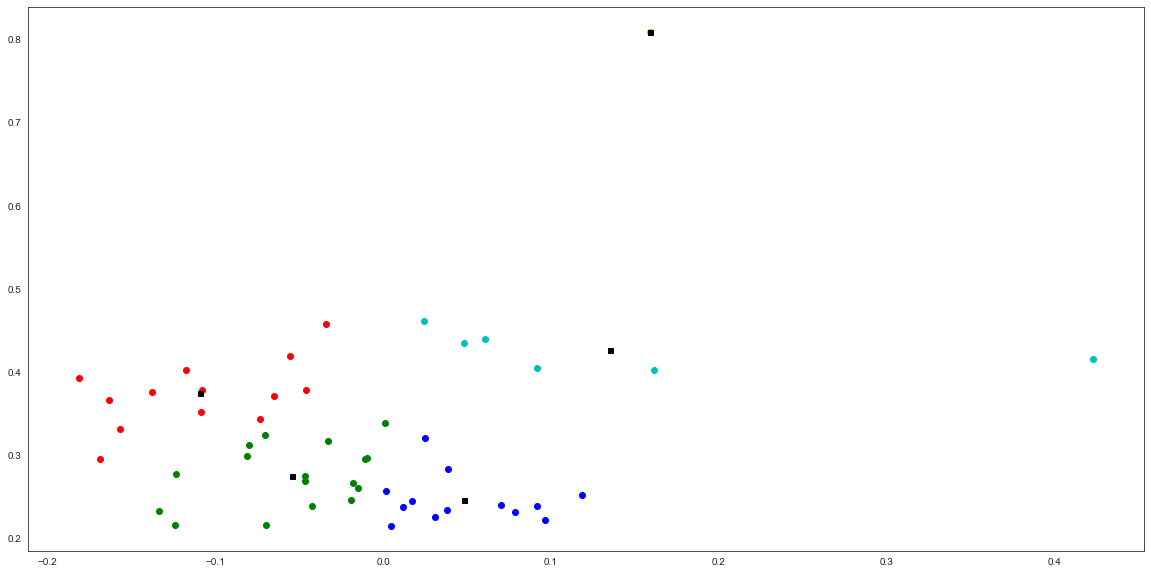

In [60]:
# Execute the K-Means Algorithm with the value of K=5 in line with the evaluation matrics optimised value for K
centroids,_ = kmeans(stockX,5)

# Assign each of the stock to a cluster
idx,_ = vq(stockX,centroids)

# Plot the cluster indices of each of the stock using the logical indexing from numpy
plt.figure(figsize=(20,10))
plt.plot(stockX[idx==0,0],stockX[idx==0,1],'ob',
     stockX[idx==1,0],stockX[idx==1,1],'oy',
     stockX[idx==2,0],stockX[idx==2,1],'or',
     stockX[idx==3,0],stockX[idx==3,1],'oc',
     stockX[idx==4,0],stockX[idx==4,1],'og')
plt.plot(centroids[:,0],centroids[:,1],'sk',markersize=5)
plt.show()

In [61]:
# Print out the stocks with the clusters they belong based on the K-Means Algorithm
stockClusters = [(name,cluster) for name, cluster in zip(stockReturns.index,idx)]

for stockPoint in stockClusters:
    print(stockPoint)

(1120, 0)
(1180, 4)
(2030, 2)
(2280, 0)
(4250, 4)
(4280, 2)
(7010, 0)
(7020, 2)
(8010, 3)
(8030, 1)
('AAIT', 2)
('ABOB', 4)
('ADCB', 4)
('ADIB', 4)
('AGTHIA', 2)
('ALDAR', 2)
('BKMB', 4)
('BKSB', 4)
('BOUK', 0)
('BRES', 4)
('BURG', 4)
('CATT', 3)
('COMB', 4)
('DANA', 3)
('ERES', 2)
('ETISALAT', 0)
('FAB', 0)
('GBKK', 4)
('GPIK', 2)
('HBMO', 4)
('HUMN', 3)
('IHGS', 2)
('KFH', 0)
('MABK', 4)
('MERS', 0)
('NBKK', 0)
('OFCI', 3)
('OIFC', 2)
('ORDS', 4)
('OTEL', 4)
('QFLS', 0)
('QINS', 4)
('QISB', 0)
('QNBK', 0)
('RAKPROP', 2)
('RNSS', 3)
('SIB', 4)
('SIHC', 2)
('WAHA', 2)
('ZAIN', 0)


<table border="0" cellpadding="0" cellspacing="0" width="100%">
        <tbody>
          <tr>
            <td>Clusters </td>
            <td>Stock Symbol </td>
            <td>Stock Exchange</td>
            <td>Sector</td>
          </tr>
          <tr>
            <td>0</td>
            <td>8010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>0</td>
            <td>CATT</td>
            <td>Kuwait Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>0</td>
            <td>DANA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>0</td>
            <td>HUMN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>0</td>
            <td>OFCI</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>0</td>
            <td>RNSS</td>
            <td>Muscat Securities    Market</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>1</td>
            <td>4250</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>4280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ADIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>BKMB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>BKSB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>BURG</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>GBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>HBMO</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>ORDS</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>OTEL</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>1</td>
            <td>QINS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>1</td>
            <td>SIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>2</td>
            <td>2030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>2</td>
            <td>7020</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>AAIT</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>2</td>
            <td>AGTHIA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>2</td>
            <td>ALDAR</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>ERES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>GPIK</td>
            <td>Kuwait Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>2</td>
            <td>IHGS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>2</td>
            <td>OIFC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>RAKPROP</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>SIHC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>2</td>
            <td>WAHA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>3</td>
            <td>8030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>1120</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>1180</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>2280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>4</td>
            <td>7010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>4</td>
            <td>ABOB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>ADCB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>BOUK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>BRES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>4</td>
            <td>COMB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>ETISALAT</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>4</td>
            <td>FAB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>KFH</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>MABK</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>4</td>
            <td>MERS</td>
            <td>Qatar Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>4</td>
            <td>NBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>QFLS</td>
            <td>Qatar Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>4</td>
            <td>QISB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>QNBK</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>4</td>
            <td>ZAIN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
        </tbody>
    </table>

The K-Means Algorithm with the optimised K=5 identify TADAWUL: 8030 as a unique stock considering it high volatility with relatively low return. TADAWUL: 8030 is now considered to be in its class, separating it from the ealier (7/50) Group-2 cluster of KMeans with K=3 in the class of stocks such as HUMN and 8010 that reports higher returns with significantly lower volatility and risk.

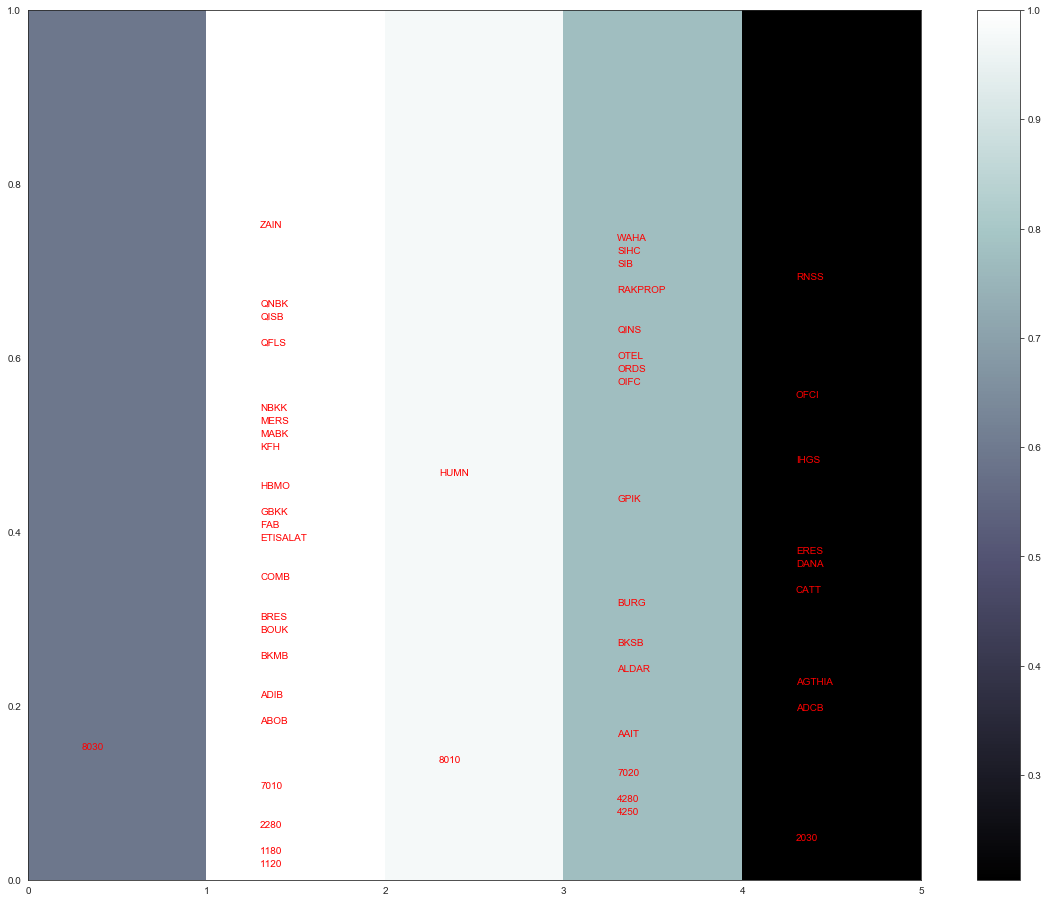

In [62]:
# Execute the Self Organising Map (SOM) ANN with the 5 by 1 map
som = MiniSom(x = 5, y = 1, input_len = 2, sigma = 0.2, learning_rate = 0.5)
som.random_weights_init(stockX)
som.train_random(data = stockX, num_iteration = 100)
bone()
pcolor(som.distance_map().T)
colorbar()
posY = 0.015
for i, x in enumerate(stockX):
    w = som.winner(x)
    plt.text(w[0] + 0.3 , w[1] + posY, stockReturns.index[i], fontsize=10, color='red')
    posY = posY + 0.015
show()

In [63]:
# Print out the SOM array for the stocks and positioning on the map
som.win_map(stockX)

defaultdict(list,
            {(1, 0): [array([0.07856221, 0.23262349]),
              array([-0.00971065,  0.29749876]),
              array([0.03860987, 0.28377344]),
              array([0.09143235, 0.23942892]),
              array([-0.01492538,  0.26102569]),
              array([-0.04652993,  0.26900374]),
              array([-0.06961391,  0.21713493]),
              array([0.03095451, 0.22643831]),
              array([-0.01094249,  0.29631713]),
              array([-0.01792679,  0.26732194]),
              array([0.0966575 , 0.22250449]),
              array([0.0249899 , 0.32147272]),
              array([-0.04242467,  0.23977123]),
              array([-0.04668042,  0.27509712]),
              array([0.01166913, 0.23871494]),
              array([-0.01911994,  0.24693446]),
              array([0.03816963, 0.23496322]),
              array([0.00463183, 0.21536228]),
              array([0.01730813, 0.24577025]),
              array([0.11865732, 0.25236338]),
              ar

In [64]:
# Collect the Best Matching Unit (BMU) of all the stocks in the map
stockList = []
for i, x in enumerate(stockX):
    idW = str(som.winner(x))
    stockList.append(idW)
    
# Print out the stocks with the clusters they belong based on the SOM Neural Network
stockClusters = [(name,cluster) for name, cluster in zip(stockReturns.index,stockList)]

for stockPoint in stockClusters:
    print(stockPoint)

(1120, '(1, 0)')
(1180, '(1, 0)')
(2030, '(4, 0)')
(2280, '(1, 0)')
(4250, '(3, 0)')
(4280, '(3, 0)')
(7010, '(1, 0)')
(7020, '(3, 0)')
(8010, '(2, 0)')
(8030, '(0, 0)')
('AAIT', '(3, 0)')
('ABOB', '(1, 0)')
('ADCB', '(4, 0)')
('ADIB', '(1, 0)')
('AGTHIA', '(4, 0)')
('ALDAR', '(3, 0)')
('BKMB', '(1, 0)')
('BKSB', '(3, 0)')
('BOUK', '(1, 0)')
('BRES', '(1, 0)')
('BURG', '(3, 0)')
('CATT', '(4, 0)')
('COMB', '(1, 0)')
('DANA', '(4, 0)')
('ERES', '(4, 0)')
('ETISALAT', '(1, 0)')
('FAB', '(1, 0)')
('GBKK', '(1, 0)')
('GPIK', '(3, 0)')
('HBMO', '(1, 0)')
('HUMN', '(2, 0)')
('IHGS', '(4, 0)')
('KFH', '(1, 0)')
('MABK', '(1, 0)')
('MERS', '(1, 0)')
('NBKK', '(1, 0)')
('OFCI', '(4, 0)')
('OIFC', '(3, 0)')
('ORDS', '(3, 0)')
('OTEL', '(3, 0)')
('QFLS', '(1, 0)')
('QINS', '(3, 0)')
('QISB', '(1, 0)')
('QNBK', '(1, 0)')
('RAKPROP', '(3, 0)')
('RNSS', '(4, 0)')
('SIB', '(3, 0)')
('SIHC', '(3, 0)')
('WAHA', '(3, 0)')
('ZAIN', '(1, 0)')


<table border="0" cellpadding="0" cellspacing="0" width="100%">
        <tbody>
          <tr>
            <td>Clusters </td>
            <td>Stock Symbol </td>
            <td>Stock Exchange</td>
            <td>Sector</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>1120</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>2280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>7010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>BOUK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>ETISALAT</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>KFH</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>MERS</td>
            <td>Qatar Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>NBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>QFLS</td>
            <td>Qatar Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>QISB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>QNBK</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(0, 0)</td>
            <td>ZAIN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>8010</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>CATT</td>
            <td>Kuwait Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>DANA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>IHGS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>OFCI</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(1, 0)</td>
            <td>RNSS</td>
            <td>Muscat Securities    Market</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>2030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>4280</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>7020</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>AAIT</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>AGTHIA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>CONSUMER</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>ALDAR</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>ERES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>GPIK</td>
            <td>Kuwait Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>OIFC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>RAKPROP</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>SIHC</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(2, 0)</td>
            <td>WAHA</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(3, 0)</td>
            <td>8030</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(3, 0)</td>
            <td>HUMN</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>1180</td>
            <td>Tadawul Stock    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>4250</td>
            <td>Tadawul Stock    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>ABOB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>ADCB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>ADIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>BKMB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>BKSB</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>BRES</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>BURG</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>COMB</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>FAB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>GBKK</td>
            <td>Kuwait Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>HBMO</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>MABK</td>
            <td>Kuwait Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>ORDS</td>
            <td>Qatar Stock Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>OTEL</td>
            <td>Muscat Securities    Market&nbsp;</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>QINS</td>
            <td>Qatar Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
          <tr>
            <td>(4, 0)</td>
            <td>SIB</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>FINANCIAL</td>
          </tr>
        </tbody>
    </table>

## Predictive Models
The objective of the predictive models is to provide the investor with an insight into the future stock close price. Four (4) entities' stocks are selected as candidates for building the predictive model. Each stock is chosen to ensure it represents one of the four sectors of the 50 stocks and from a unique cluster fropm the K-Means (K=5).

The shortlisted stocks are as follows:
<table border="0" cellpadding="0" cellspacing="0" width="100%">
        <tbody>
          <tr>
            <td>Clusters </td>
            <td>Stock Symbol </td>
            <td>Stock Exchange</td>
            <td>Sector</td>
          </tr>
          <tr>
            <td>0</td>
            <td>CATT</td>
            <td>Kuwait Stock Exchange</td>
            <td>CONSUMER</td>
          </tr>
            <tr>
            <td>2</td>
            <td>RAKPROP</td>
            <td>Abu Dhabi Securities    Exchange</td>
            <td>SERVICES</td>
          </tr>
          <tr>
            <td>3</td>
            <td>8030</td>
            <td>Tadawul Stock Exchange</td>
            <td>FINANCIAL</td>
          </tr>
            <tr>
            <td>4</td>
            <td>QFLS</td>
            <td>Qatar Stock Exchange</td>
            <td>ENERGY</td>
          </tr>
        </tbody>
    </table>

The predictive business problem will be approached from two different perspectives:

Regression: The regression approach to the business problem as a Multivariate Time-Series Analysis will predict the absolute future value of the close stock price. The regressor models that have been identified as candidates to build the model are Auto-Regressive Integrated Moving Average (ARIMA) and combination of the Long Short Term Memory (LSTM) and Convolutional Neural Network (CNN).

Classification: The classification approach to the business problem will leverage the technical analysis indicators prepared in the data processing phase to predict the direction of the future close stock price as to whether it will rise or fall. The shortlisted machine learning techniques to build the classification model are LSTM and Apriori algorithm for Association Rule Mining.

In [65]:
StockCATT

Symbol  Close   Open   High    Low     Volume         SMA         EMA   MOM        RSI        ROC      MACD      BB       CHAIKIN       STOCH      STOCHD
Date                                                                                                                                                                
2020-05-07   CATT  195.0  195.0  195.0  195.0      100.0  184.238095  186.314229  11.0  72.685145   8.333333  2.093320  184.30  1.769128e+06  100.000000  100.000000
2020-05-06   CATT  193.0  196.0  196.0  193.0   510920.0  184.714286  186.998438  13.0  67.408833   5.464481  2.248883  184.75  1.311496e+06   84.210526   94.736842
2020-05-05   CATT  190.0  191.0  196.0  189.0  1340000.0  185.000000  187.302141  10.0  60.492629   3.260870  2.136921  185.25  1.049984e+06   68.421053   84.210526
2020-05-04   CATT  187.0  180.0  196.0  180.0  1990000.0  185.333333  187.271880   1.0  54.609499   3.888889  1.816211  185.60  4.864569e+06   52.631579   68.421053
2020-05-03   CATT  179.0  180.0  180.0  179.0   352490.0  185.285714  186.451016  -6.0  42.921525  -0.555556  0.983539  185.55  5.383201e+06   10.526316   43.859649
...           ...    ...    ...    ...    ...        ...         ...         ...   ...        ...        ...       ...     ...           ...         ...         ...
2014-07-03   CATT  228.0  228.0  228.0  228.0    25000.0  210.476190  212.023022  22.0  65.677831   9.615385  7.328948  210.60  1.019886e+06   94.117647   89.705882
2014-07-02   CATT  238.0  224.0  238.0  224.0    17000.0  211.904762  214.384566  34.0  69.584450  14.423077  8.451703  212.20  1.319687e+06  100.000000   98.039216
2014-06-30   CATT  232.0  234.0  234.0  232.0     1500.0  213.142857  215.985969  22.0  64.928560  12.621359  8.756407  213.40  1.147855e+06   82.352941   92.156863
2014-06-26   CATT  236.0  228.0  238.0  228.0    21110.0  214.476190  217.805426  28.0  66.497705  13.461538  9.214435  215.10  9.957417e+05   94.117647   92.156863
2014-06-25   CATT  238.0  246.0  246.0  238.0     1850.0  216.190476  219.641297  34.0  67.266588  17.821782  9.627825  216.60  8.282992e+05   80.952381   85.807656

[1053 rows x 16 columns]

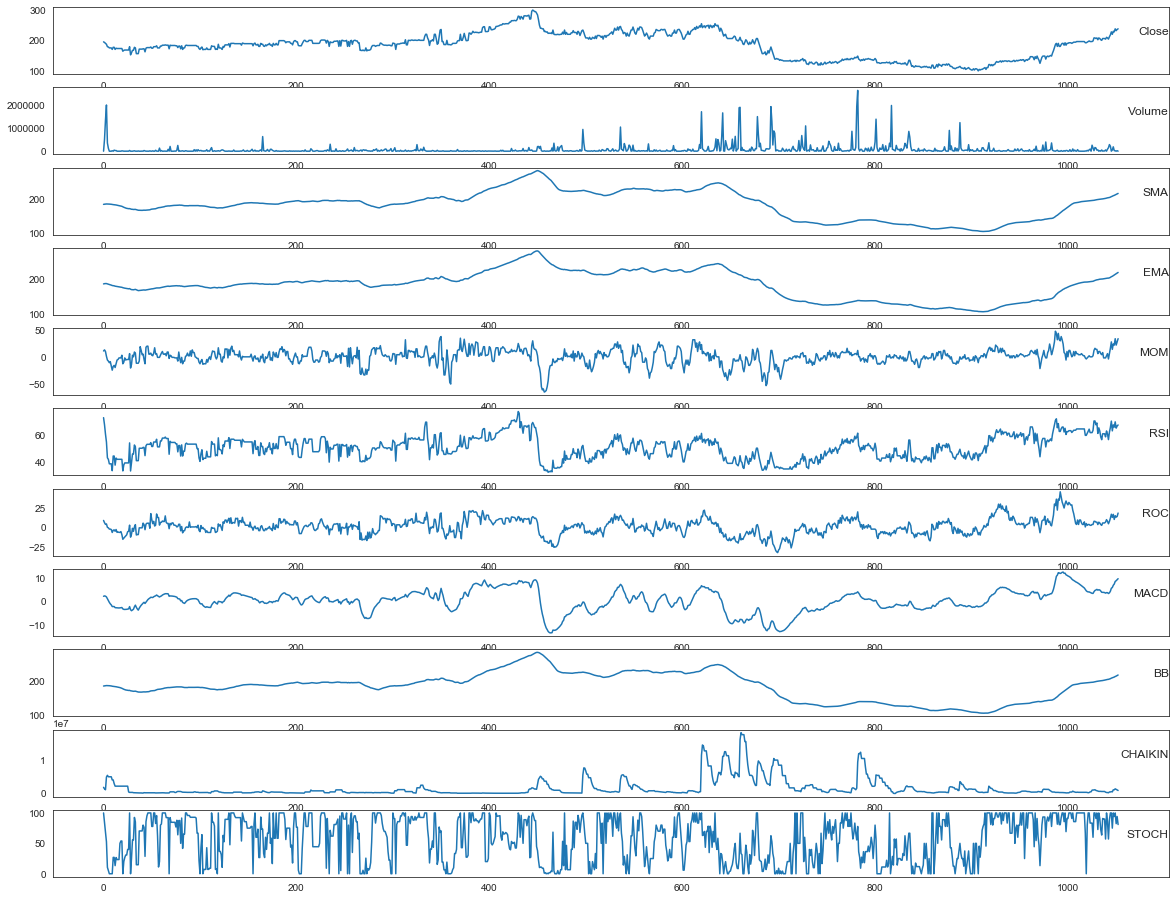

In [66]:
# Create the charts for the created features
vals = StockCATT.values
cols = [1,5,6,7,8,9,10,11,12,13,14]
i = 1
plt.figure()
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(vals[:, col])
    plt.title(StockCATT.columns[col], y=0.5, loc='right')
    i += 1
plt.show()

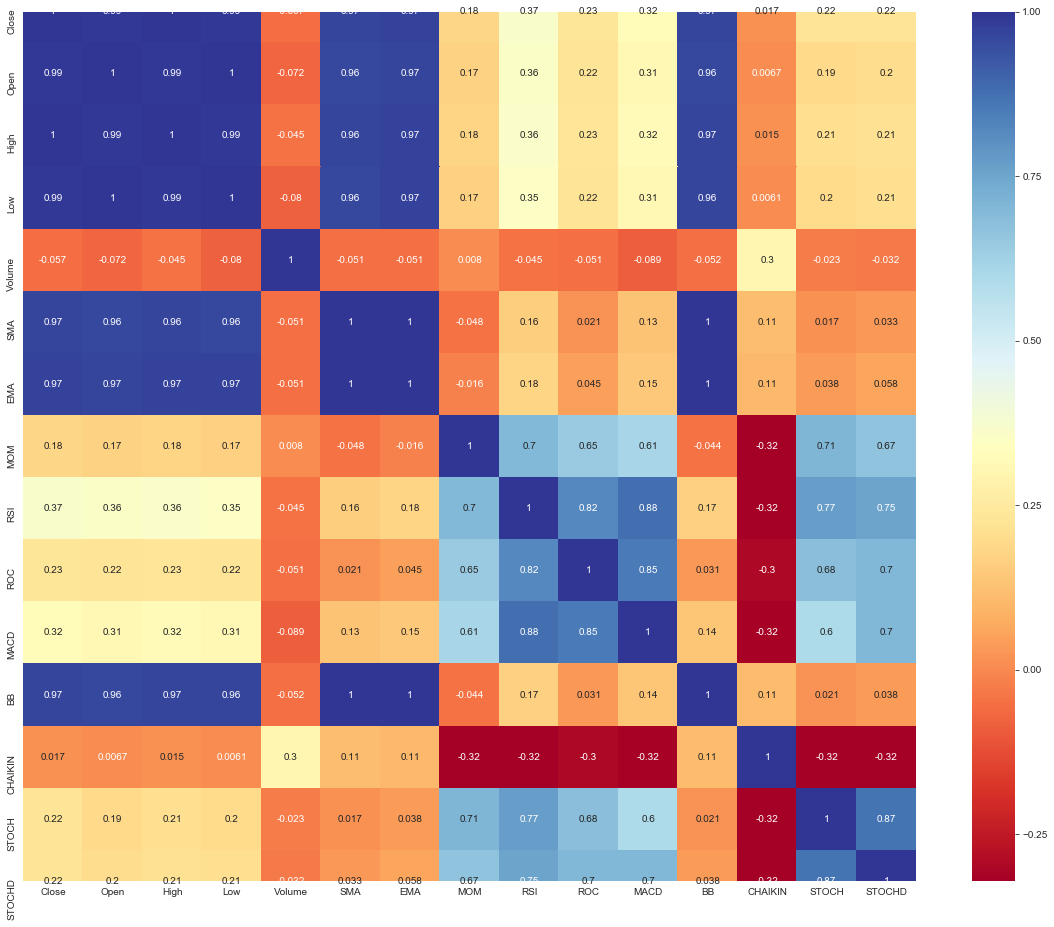

In [67]:
# Check the multicollinearity of the features in the StockCATT Data Frame
corrmatrix = StockCATT.corr()
high_corr_features = corrmatrix.index
sb.heatmap(StockCATT[high_corr_features].corr(),annot = True, cmap = "RdYlBu")

In [68]:
# Extract the Close feature from StockCATT dataframe into predictStockCATTClose dataframe
predictStockCATTClose = StockCATT[['Close']]
predictStockCATTClose = predictStockCATTClose.sort_index(ascending='True')

In [69]:
# Create the extracted dataframes with the key features for predictStockCATT, predictStockRAKPROP, predictStock8030 and predictStockQFLS 
predictStockCATT = StockCATT[['Open','High','Low','Volume','SMA','EMA','MOM', 'RSI', 'ROC', 'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD','Close']]
predictStockCATT = predictStockCATT.sort_index(ascending='True')

predictStockRAKPROP = StockRAKPROP[['Open','High','Low','Volume','SMA','EMA','MOM', 'RSI', 'ROC', 'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD','Close']]
predictStockRAKPROP = predictStockRAKPROP.sort_index(ascending='True')

predictStock8030 = Stock8030[['Open','High','Low','Volume','SMA','EMA','MOM', 'RSI', 'ROC', 'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD','Close']]
predictStock8030 = predictStock8030.sort_index(ascending='True')

predictStockQFLS = StockQFLS[['Open','High','Low','Volume','SMA','EMA','MOM', 'RSI', 'ROC', 'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD','Close']]
predictStockQFLS = predictStockQFLS.sort_index(ascending='True')

In [70]:
# Show the structure and content (head and tail) of the predictStockCATTClose dataframe
predictStockCATTClose

Close
Date             
2014-06-25  238.0
2014-06-26  236.0
2014-06-30  232.0
2014-07-02  238.0
2014-07-03  228.0
...           ...
2020-05-03  179.0
2020-05-04  187.0
2020-05-05  190.0
2020-05-06  193.0
2020-05-07  195.0

[1053 rows x 1 columns]

In [71]:
# Show the structure and content (head and tail) of the predictStockCATT dataframe
predictStockCATT

Open   High    Low     Volume         SMA         EMA   MOM        RSI        ROC      MACD      BB       CHAIKIN       STOCH      STOCHD  Close
Date                                                                                                                                                         
2014-06-25  246.0  246.0  238.0     1850.0  216.190476  219.641297  34.0  67.266588  17.821782  9.627825  216.60  8.282992e+05   80.952381   85.807656  238.0
2014-06-26  228.0  238.0  228.0    21110.0  214.476190  217.805426  28.0  66.497705  13.461538  9.214435  215.10  9.957417e+05   94.117647   92.156863  236.0
2014-06-30  234.0  234.0  232.0     1500.0  213.142857  215.985969  22.0  64.928560  12.621359  8.756407  213.40  1.147855e+06   82.352941   92.156863  232.0
2014-07-02  224.0  238.0  224.0    17000.0  211.904762  214.384566  34.0  69.584450  14.423077  8.451703  212.20  1.319687e+06  100.000000   98.039216  238.0
2014-07-03  228.0  228.0  228.0    25000.0  210.476190  212.023022  22.0  65.677831   9.615385  7.328948  210.60  1.019886e+06   94.117647   89.705882  228.0
...           ...    ...    ...        ...         ...         ...   ...        ...        ...       ...     ...           ...         ...         ...    ...
2020-05-03  180.0  180.0  179.0   352490.0  185.285714  186.451016  -6.0  42.921525  -0.555556  0.983539  185.55  5.383201e+06   10.526316   43.859649  179.0
2020-05-04  180.0  196.0  180.0  1990000.0  185.333333  187.271880   1.0  54.609499   3.888889  1.816211  185.60  4.864569e+06   52.631579   68.421053  187.0
2020-05-05  191.0  196.0  189.0  1340000.0  185.000000  187.302141  10.0  60.492629   3.260870  2.136921  185.25  1.049984e+06   68.421053   84.210526  190.0
2020-05-06  196.0  196.0  193.0   510920.0  184.714286  186.998438  13.0  67.408833   5.464481  2.248883  184.75  1.311496e+06   84.210526   94.736842  193.0
2020-05-07  195.0  195.0  195.0      100.0  184.238095  186.314229  11.0  72.685145   8.333333  2.093320  184.30  1.769128e+06  100.000000  100.000000  195.0

[1053 rows x 15 columns]

In [72]:
# Show the structure and content (head and tail) of the predictStockRAKPROP dataframe
predictStockRAKPROP

Open   High    Low      Volume       SMA       EMA    MOM        RSI       ROC      MACD       BB       CHAIKIN      STOCH     STOCHD  Close
Date                                                                                                                                                     
2014-06-15  1.100  1.110  1.060  13250000.0  0.990952  1.008244  0.170  54.520264 -1.851852  0.009229  0.98900 -3.163401e+07  86.111111  88.299663  1.060
2014-06-16  1.070  1.070  1.020  17000000.0  0.991905  1.003068  0.200  52.260883 -6.363636  0.005551  0.98750 -3.013509e+07  84.848485  90.909091  1.030
2014-06-17  1.020  1.060  1.020  14770000.0  0.995238  1.000375  0.220  54.856310 -5.357143  0.003829  0.99000 -3.007993e+07  93.939394  93.939394  1.060
2014-06-18  1.060  1.070  1.040   6800000.0  0.998095  0.994413  0.100  54.856310 -4.504505 -0.001478  0.99200 -3.370621e+07  93.939394  92.929293  1.060
2014-06-19  1.060  1.080  1.060  19480000.0  1.000476  0.987854  0.050  54.856310  6.000000 -0.008231  0.99500 -3.462068e+07  93.939394  87.422613  1.060
...           ...    ...    ...         ...       ...       ...    ...        ...       ...       ...      ...           ...        ...        ...    ...
2020-05-05  0.365  0.365  0.350   1630000.0  0.344952  0.346628 -0.003  50.998280 -1.685393  0.000531  0.34420 -3.383549e+06  44.444444  47.643098  0.350
2020-05-06  0.365  0.365  0.344   1360000.0  0.345238  0.346257 -0.001  48.755656 -1.142857  0.000313  0.34470 -3.216143e+06  50.000000  59.090909  0.346
2020-05-07  0.340  0.343  0.340    409010.0  0.345429  0.346285  0.001  47.023857 -3.380282  0.000389  0.34520 -3.353647e+06  48.484848  57.575758  0.343
2020-05-10  0.345  0.353  0.343    911100.0  0.346000  0.346655  0.009  52.675135  1.146132  0.000749  0.34555 -3.893097e+06  78.787879  57.575758  0.353
2020-05-11  0.345  0.350  0.340   1970000.0  0.345810  0.345932  0.015  45.858643 -3.116147  0.000316  0.34565 -4.341638e+06  45.454545  59.595960  0.342

[1467 rows x 15 columns]

In [73]:
# Show the structure and content (head and tail) of the predictStock8030 dataframe
predictStock8030

Open   High    Low     Volume        SMA        EMA   MOM        RSI        ROC      MACD      BB       CHAIKIN      STOCH     STOCHD  Close
Date                                                                                                                                                     
2014-06-15  32.50  32.80  32.40   482290.0  35.033333  35.273907 -2.10  24.189090 -13.793103 -2.032828  34.945  4.163472e+05  17.073171  18.031482  32.50
2014-06-16  32.50  32.80  32.40   673690.0  35.280952  35.551298 -2.00  24.385914 -14.435696 -2.039900  35.160  5.736956e+05  17.021277  19.916183  32.60
2014-06-17  32.60  32.90  31.80   604630.0  35.542857  35.846427 -2.40  24.966341 -14.322917 -2.029438  35.415  5.870126e+05  20.000000  16.806527  32.90
2014-06-18  32.90  34.10  32.90  1160000.0  35.804762  36.141070 -1.90  27.007018 -12.176166 -2.017111  35.675  3.319237e+05  22.727273  13.558664  33.90
2014-06-19  34.10  34.40  34.10   724030.0  36.028571  36.365177 -2.30  27.434139 -12.113402 -2.073856  35.900  1.519068e+05   7.692308  15.384615  34.10
...           ...    ...    ...        ...        ...        ...   ...        ...        ...       ...     ...           ...        ...        ...    ...
2020-05-03  17.50  17.60  16.32  1180000.0  20.164762  19.186300 -5.34  26.166536 -26.816143 -0.979347  20.043  1.155662e+06   2.839117  10.278925  16.32
2020-05-04  16.30  17.12  16.14   986010.0  20.449524  19.502075 -3.66  28.517466 -23.423423 -0.878414  20.357  1.711082e+06  13.564669  16.210860  17.00
2020-05-05  17.20  17.60  17.14   789790.0  20.697143  19.780555 -2.64  30.596496 -19.541284 -0.796867  20.622  1.772321e+06  14.432990  19.424110  17.54
2020-05-06  17.90  18.48  17.78  1160000.0  20.900000  20.032779 -2.30  32.519916 -14.933837 -0.728218  20.855  2.090245e+06  20.634921  22.405321  18.00
2020-05-07  18.02  18.50  17.90  1740000.0  21.050476  20.264526 -2.10  34.211981 -11.464355 -0.669480  21.045  2.565820e+06  23.204420  23.319222  18.38

[1460 rows x 15 columns]

In [74]:
# Show the structure and content (head and tail) of the predictStockQFLS dataframe
predictStockQFLS

Open    High     Low     Volume        SMA        EMA    MOM        RSI       ROC      MACD        BB       CHAIKIN      STOCH     STOCHD   Close
Date                                                                                                                                                           
2014-06-15  18.357  18.434  18.136   931720.0  18.078095  18.172928  0.552  48.683736 -0.697586 -0.060299  18.06710 -1.514221e+06  62.222222  57.805213  18.221
2014-06-16  18.145  18.179  17.898   982840.0  18.084190  18.168121  0.314  45.079524 -1.895735 -0.072873  18.07095 -1.509559e+06  44.773663  62.716049  18.009
2014-06-17  17.847  18.417  17.847  1220000.0  18.100762  18.184033  0.204  49.158841 -1.333765 -0.066277  18.08795 -1.619076e+06  66.419753  72.522678  18.272
2014-06-18  18.272  18.680  18.264   668690.0  18.112524  18.175237  0.094  51.311048 -1.541096 -0.083672  18.09220 -1.904605e+06  76.954733  72.963405  18.400
2014-06-19  18.349  18.485  18.196   488820.0  18.126238  18.152760  0.068  48.757124 -0.322299 -0.117691  18.09815 -2.017427e+06  74.193548  64.516129  18.247
...            ...     ...     ...        ...        ...        ...    ...        ...       ...       ...       ...           ...        ...        ...     ...
2020-05-03  16.010  16.080  15.910  1120000.0  16.215714  16.140314  0.120  35.200691 -5.633803 -0.108662  16.17150 -9.288576e+05  51.428571  32.539683  16.080
2020-05-04  16.050  16.050  15.900   305210.0  16.261429  16.146958  0.020  28.916703 -6.000000 -0.120386  16.22250 -1.136896e+06  22.857143  15.813492  15.980
2020-05-05  16.000  16.050  15.950   383550.0  16.310000  16.165541  0.020  30.025961 -5.150977 -0.124614  16.27550 -1.244356e+06  23.333333   8.194444  16.020
2020-05-06  16.050  16.050  15.950   397770.0  16.351429  16.181925 -0.010  25.969014 -6.062390 -0.131741  16.32450 -1.320832e+06   1.250000   5.277778  15.960
2020-05-07  16.050  16.050  15.950   719000.0  16.400476  16.207225 -0.050  25.281391 -5.228758 -0.133605  16.37100 -1.280957e+06   0.000000   9.305556  15.950

[1461 rows x 15 columns]

In [75]:
# Export the csv files for the selected dataframes for further machine learning techniques
predictStockCATT.to_csv(r'C:\sandbox\Python\Fundy\Stocks\NET\stockCATT.csv')
predictStockRAKPROP.to_csv(r'C:\sandbox\Python\Fundy\Stocks\NET\stockRAKPROP.csv')
predictStock8030.to_csv(r'C:\sandbox\Python\Fundy\Stocks\NET\stock8030.csv')
predictStockQFLS.to_csv(r'C:\sandbox\Python\Fundy\Stocks\NET\stockQFLS.csv')

In [76]:
# slipt the predictStockCATTClose dataframe into train and test dataframes
predictStockCATTClose_train = predictStockCATTClose['2014-06-15':'2020-03-01'].sort_index(ascending='True')
predictStockCATTClose_test = predictStockCATTClose['2020-03-02':'2020-06-14'].sort_index(ascending='True')

In [77]:
# Print he sahe of predictStockCATTClose_train and predictStockCATTClose_test dataframes
print(predictStockCATTClose_train.shape,predictStockCATTClose_test.shape)

(1006, 1) (47, 1)


In [78]:
# slipt the predictStockCATT dataframe into train and test dataframes
predictStockCATT_train = predictStockCATT['2014-06-15':'2020-03-01'].sort_index(ascending='True')
predictStockCATT_test = predictStockCATT['2020-03-02':'2020-06-14'].sort_index(ascending='True')

In [79]:
# Print he sahe of predictStockCATT_train and predictStockCATT_test dataframes
print(predictStockCATT_train.shape,predictStockCATT_test.shape)

(1006, 15) (47, 15)


### Auto-Regressive Integrated Moving Average (ARIMA)

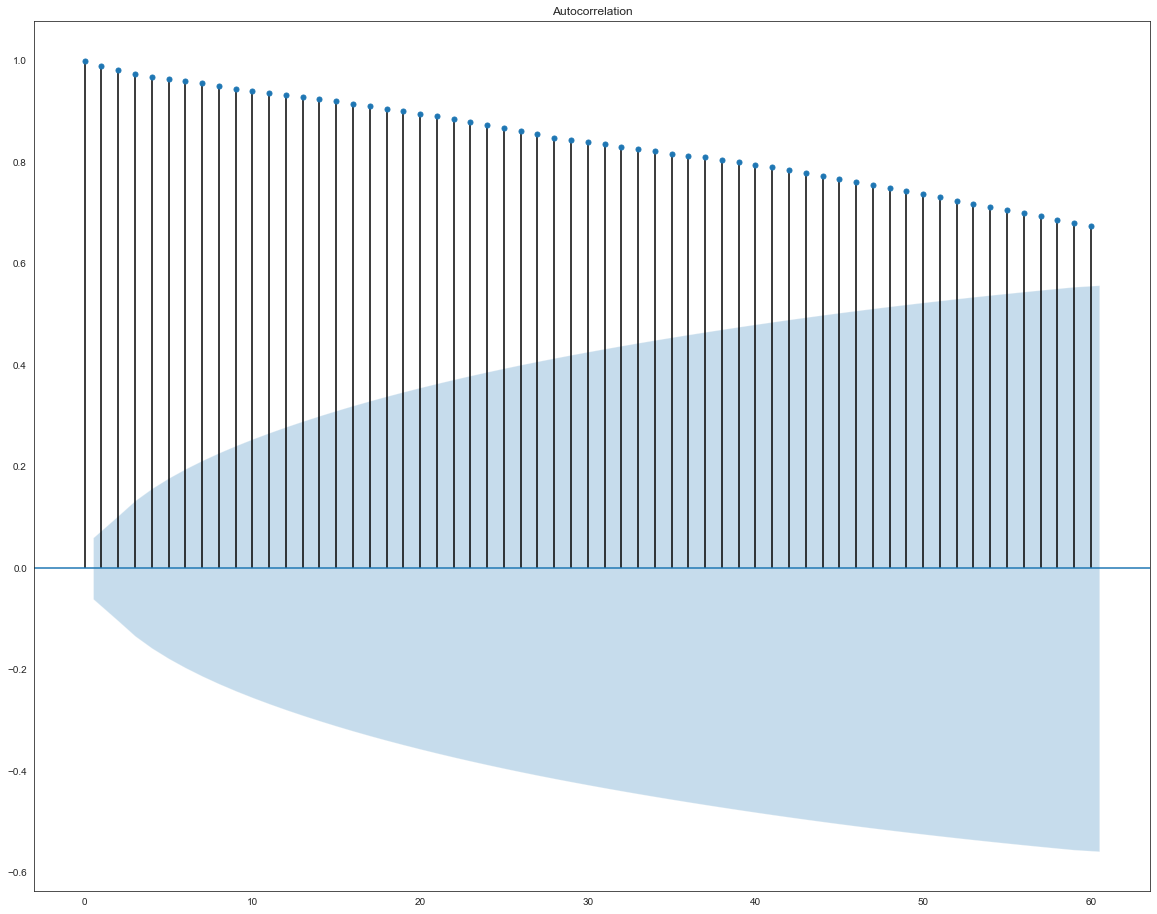

In [80]:
# Evaluate the Autocorrelation Function on the CATT Close Stock Prices using a 60 days lag
plot_acf(predictStockCATTClose, lags = 60);

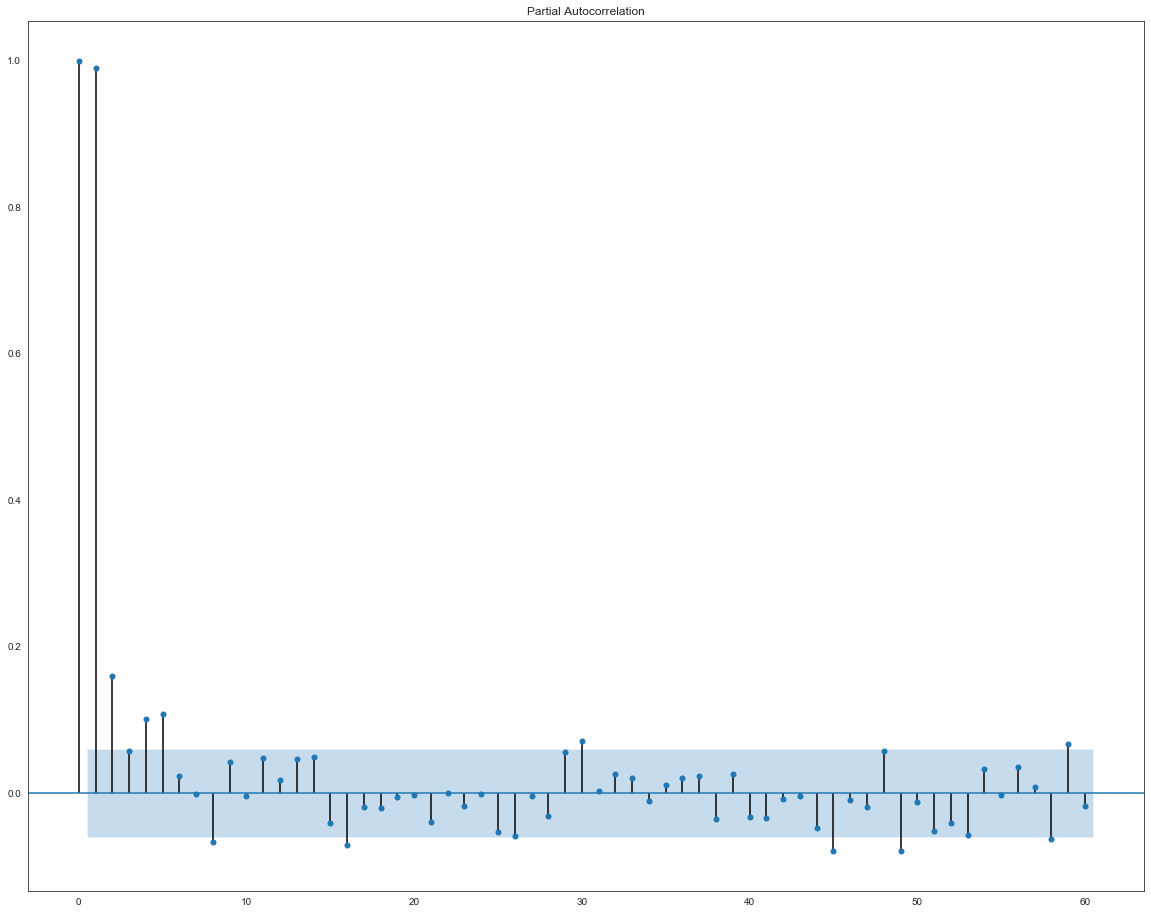

In [81]:
# Evaluate the Partial Autocorrelation Function on the CATT Close Stock Prices using a 60 days lag
plot_pacf(predictStockCATTClose, lags = 60);

In [82]:
# Evaluate the stationality of the CATT Close Stock Prices on Monthly Basis
adfuller(predictStockCATTClose['Close'])

(-1.7423099546070813,
 0.4094554252131423,
 4,
 1048,
 {'1%': -3.436605142651622,
  '5%': -2.8643018096684587,
  '10%': -2.568240496510984},
 6611.005295920289)

The Autocorrelation Function (ACF) and high P-value (0.4095) of the Augmented Dickey Fuller (ADF) Test assert that the CATT Close Stock Prices are non-stationary.

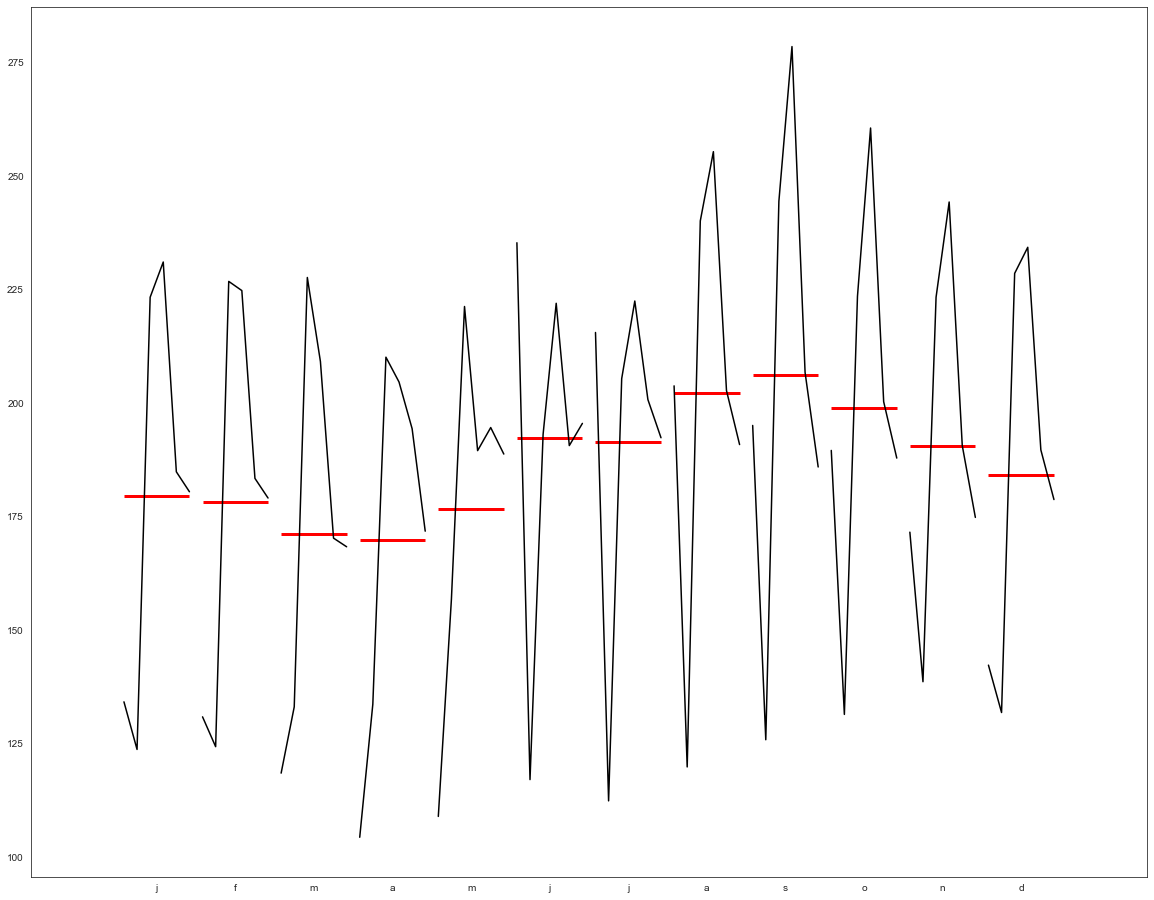

In [83]:
# Evaluate the seasonality of the CATT Close Stock Prices on Monthly Basis
predictStockCATTCloseM = predictStockCATTClose['Close'].resample(rule='M').mean()
month_plot(predictStockCATTCloseM);

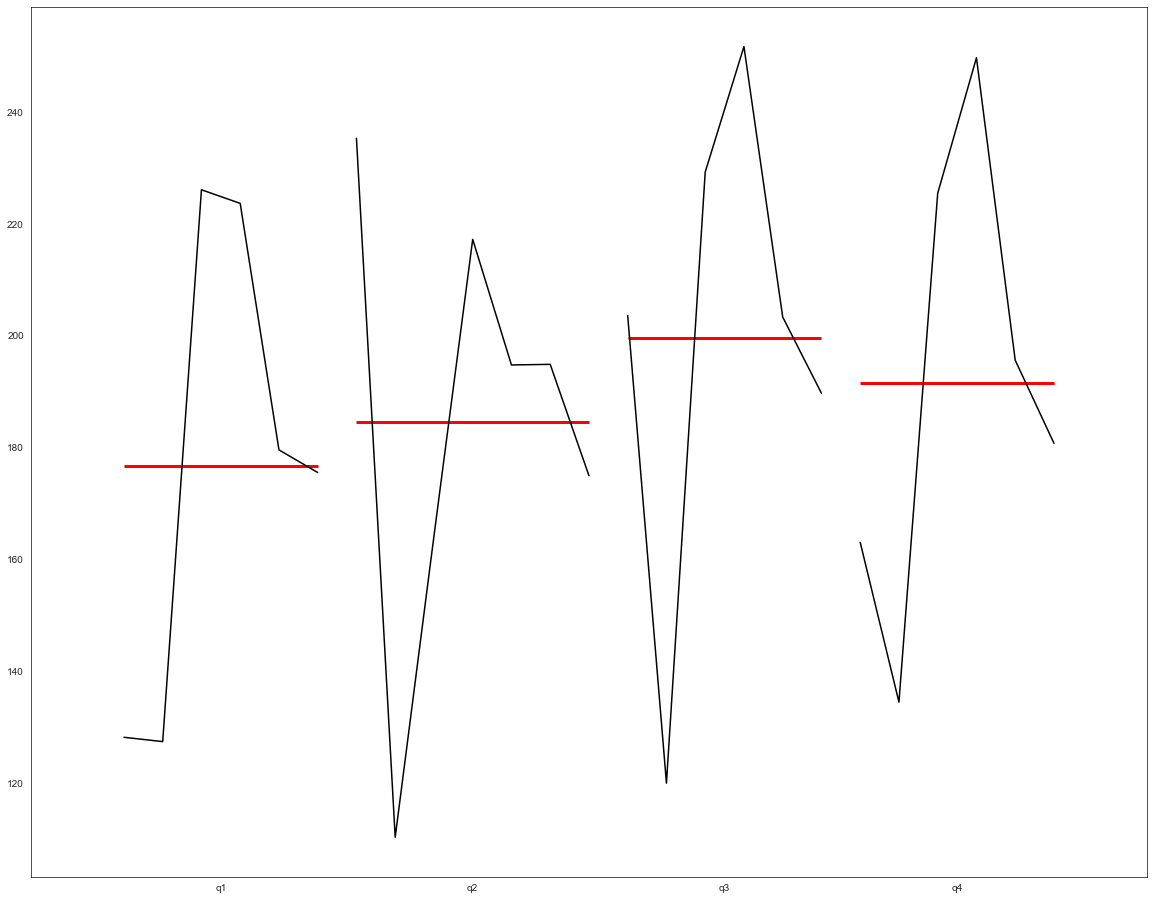

In [84]:
# Evaluate the seasonality of the CATT Close Stock Prices on Quarterly Basis
predictStockCATTCloseQ = predictStockCATTClose['Close'].resample(rule='Q').mean()
quarter_plot(predictStockCATTCloseQ);

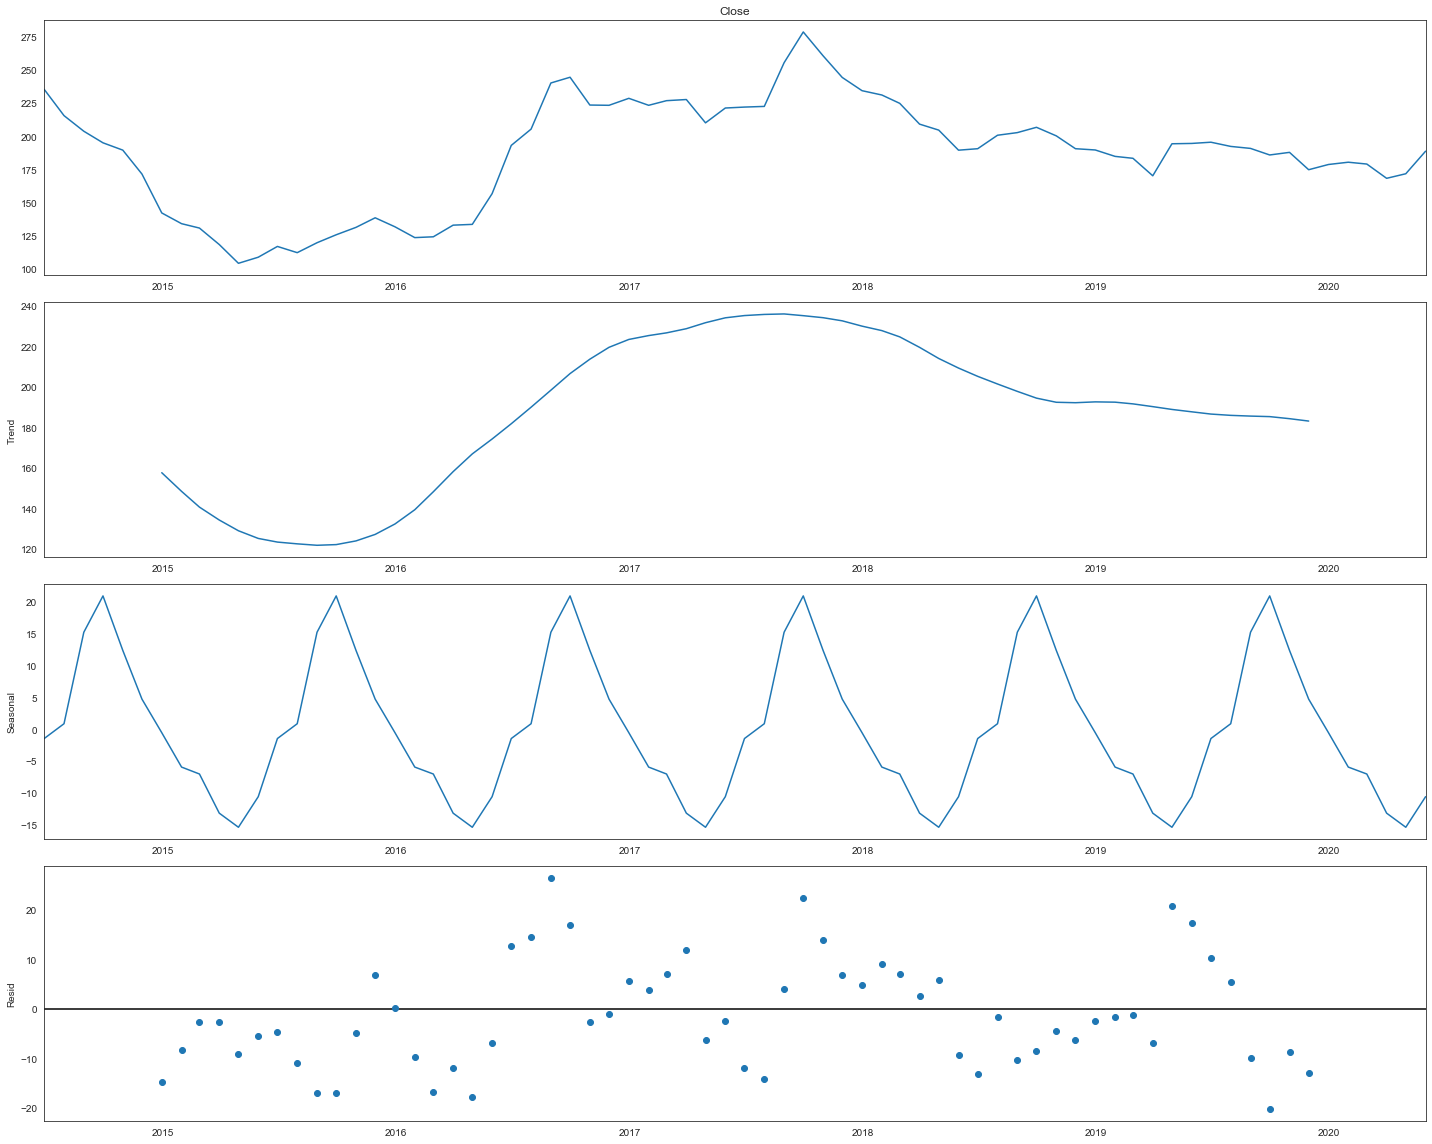

In [85]:
# Assess the seasonality of the CATT Close Stock Price on Weekly Basis with Seasonal Decomposition
sResult = seasonal_decompose(pd.DataFrame(data=predictStockCATTClose['Close'].resample(rule='M').mean().rename('Close'))['Close'],model='add')
sResult.plot();

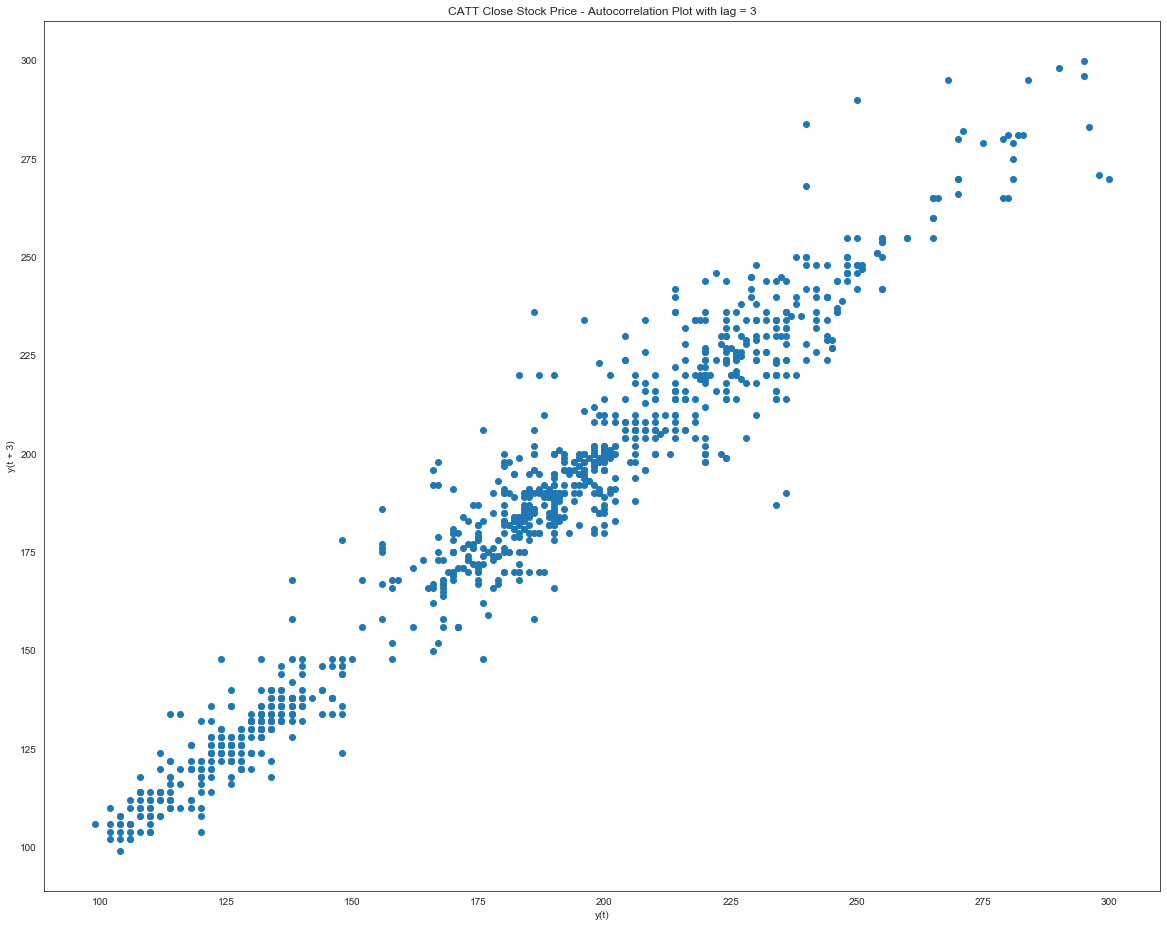

In [86]:
# Create the Autocorrelation Plot for CATT Close Stock price with lag = 3
plt.figure()
lag_plot(predictStockCATTClose['Close'], lag = 3)
plt.title('CATT Close Stock Price - Autocorrelation Plot with lag = 3')
plt.show()

The decomposition of the time series data into trend, seasonal and residual components show that there is somewhat level of seasonality in the historical stock prices of CATT, however, is very minimal and negligible. The trend and seasonal components seem to capture most of the data in the time series as there is only a scramble of points in the residual, which shows that the stock price can be predicted. This is also corroborated with the lag-plot that shows significant autocorrelation of the data, as earlier identified by the PCF plot to affirm that indeed the preceding observations are relevant to predict the subsequent ones. 

In [87]:
# Apply GridSearch for the p,d and q parameters
stepwise_fit = auto_arima(predictStockCATTClose['Close'], seasonal = False)

In [88]:
# Show the best paramters for the ARIMA model
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1053
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3374.656
Date:                Tue, 05 Jan 2021   AIC                           6755.311
Time:                        02:31:43   BIC                           6770.187
Sample:                             0   HQIC                          6760.951
                               - 1053                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4789      0.075      6.353      0.000       0.331       0.627
ma.L1         -0.6577      0.065    -10.079      0.000      -0.786      -0.530
sigma2        35.7928      0.932     38.400      0.000      33.966      37.620
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               623.59
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
# Pass the train/test dataframes' values into the train and test numpy arrays
train = predictStockCATTClose_train['Close'].values
test = predictStockCATTClose_test['Close'].values

# Create the ARIMA benchmark model for the Univariate & Multivariate Analysis
stockHistory = [x for x in train]
arimaModel_predictions = []
N_test_observations = len(test)
for time_point in range(N_test_observations):
    arimaModel = ARIMA(stockHistory, order=(1,1,1))
    arimaModel_fit = arimaModel.fit(disp=0)
    output = arimaModel_fit.forecast()
    yhat = output[0]
    arimaModel_predictions.append(yhat)
    true_test_value = test[time_point]
    stockHistory.append(true_test_value)

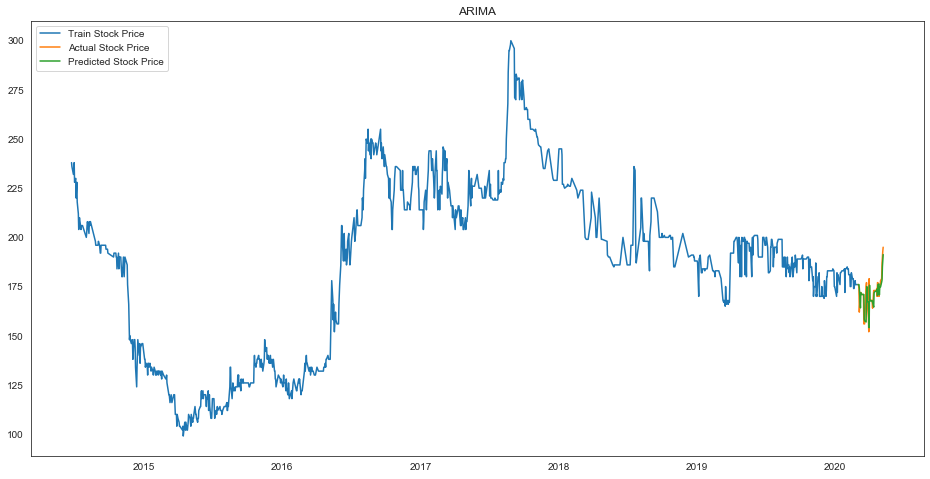

In [101]:
# Show the chart of train, actual and predicted stock prices
predictStockCATTClose_test['PredClose'] = arimaModel_predictions
plt.figure(figsize=(16,8))
plt.plot(predictStockCATTClose_train['Close'], label = "Train Stock Price")
plt.plot(predictStockCATTClose_test['Close'], label = "Actual Stock Price")
plt.plot(predictStockCATTClose_test['PredClose'], label = "Predicted Stock Price")
plt.title("ARIMA")
plt.legend(loc='upper left')
plt.show()

In [102]:
# Print out the performance metrics
mae = mean_absolute_error(test, arimaModel_predictions)
mape = np.mean(np.abs((test, arimaModel_predictions) / test)) * 100
mse = mean_squared_error(test, arimaModel_predictions)
rmse = np.sqrt(mean_squared_error(test, arimaModel_predictions))

print(f'The Mean Absolute Error (MAE) for ARIMA is {mae}')
print(f'The Mean Absolute Percentage Error (MAPE) for ARIMA is {mape}')
print(f'The Mean Squared Error (MSE) for ARIMA is {mse}')
print(f'The Root Mean Square Error (RMSE) for ARIMA is {rmse}')

The Mean Absolute Error (MAE) for ARIMA is 4.04216346305524
The Mean Absolute Percentage Error (MAPE) for ARIMA is [99.87527053]
The Mean Squared Error (MSE) for ARIMA is 43.09193794612199
The Root Mean Square Error (RMSE) for ARIMA is 6.564444983859792
